### Importing Libraries


In [114]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import datetime
import seaborn as sns
import time

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Reading train CSV File 

In [115]:
train = pd.read_csv('data/train.csv')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


#### Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.'
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

### Exploratory Data Analysis for train dataset

In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [117]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


### Getting to know how the data is classified:

In [118]:
train.shape

(1017209, 9)

In [119]:
train['DayOfWeek'].unique()

array([5, 4, 3, 2, 1, 7, 6], dtype=int64)

In [120]:
train['Open'].unique()

array([1, 0], dtype=int64)

In [121]:
train['Promo'].unique()

array([1, 0], dtype=int64)

In [122]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [123]:
train['SchoolHoliday'].unique()

array([1, 0], dtype=int64)

#### Convert date column to datetime type

In [124]:
train['Date'] = pd.to_datetime(train['Date'])
train['Date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


#### Checking null values

In [126]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

- There are no null values in train data 

####  Graphical Visualizatio of the variables available in the train dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002149003F648>,
      dtype=object)

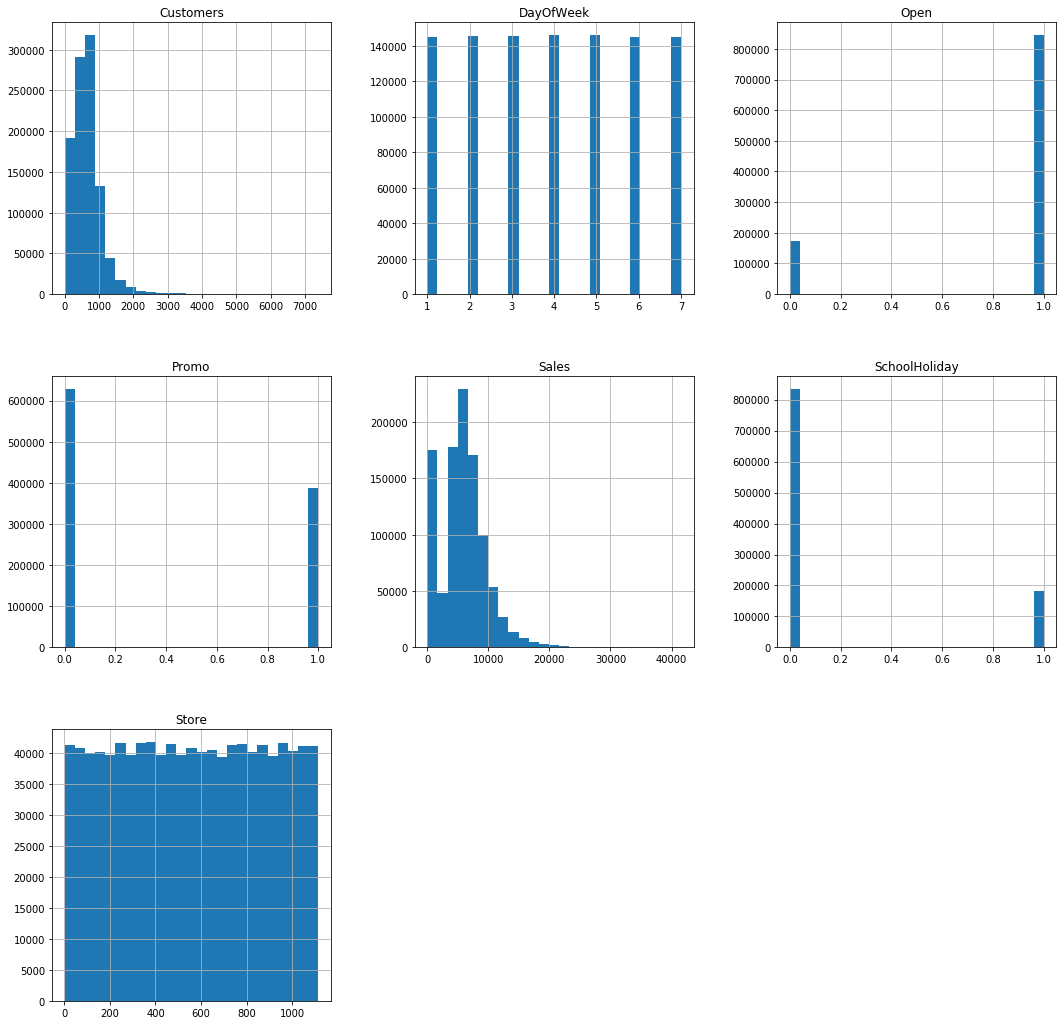

In [127]:
train.hist(bins=25,figsize = (18,18))

The most important information from these plots are:

- Most of the sales are happening around the value of 5 to 6 thousand euros
- Number of clients per day shows a greater frequency around 600
- The store was on sale (variable Promo) around 40% of the time it was open

We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.

In [128]:
# data extraction

train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month
train['Day'] = pd.DatetimeIndex(train['Date']).day
train['WeekOfYear'] = pd.DatetimeIndex(train['Date']).weekofyear

# adding new variable, can use 'new cols' = function('existing cols')
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

**ECDF: empirical cumulative distribution function**

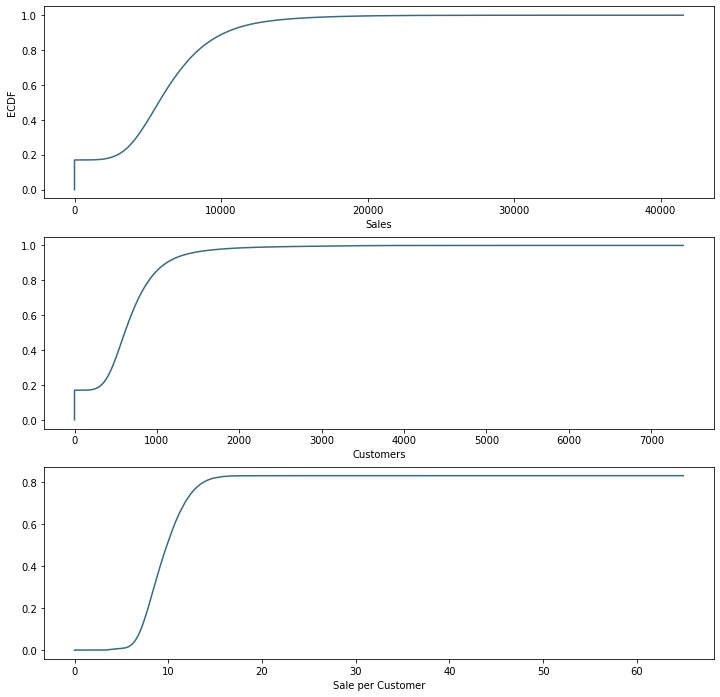

In [129]:
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 12))

# very good function ecdf to plot cdf of any columns
plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, Need to check is it only due to the fact that the store is closed?

**Missing values**

Closed stores and zero sales stores

In [130]:
# closed stores
print(train[(train.Open == 0) & (train.Sales == 0)].shape[0])
train[(train.Open == 0) & (train.Sales == 0)].head()

172817


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
291,292,5,2015-07-31,0,0,0,1,0,1,2015,7,31,31,NaN
875,876,5,2015-07-31,0,0,0,1,0,1,2015,7,31,31,NaN
1406,292,4,2015-07-30,0,0,0,1,0,1,2015,7,30,31,NaN
1990,876,4,2015-07-30,0,0,0,1,0,1,2015,7,30,31,NaN
2521,292,3,2015-07-29,0,0,0,1,0,1,2015,7,29,31,NaN


There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [131]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape[0])
zero_sales.head(5)

In total:  54


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
86825,971,5,2015-05-15,0,0,1,0,0,1,2015,5,15,20,NaN
142278,674,4,2015-03-26,0,0,1,0,0,0,2015,3,26,13,NaN
196938,699,4,2015-02-05,0,0,1,1,0,0,2015,2,5,6,NaN
322053,708,3,2014-10-01,0,0,1,1,0,0,2014,10,1,40,NaN
330176,357,1,2014-09-22,0,0,1,0,0,0,2014,9,22,39,NaN


Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.

In [132]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 14)


### Reading Store CSV File 

In [133]:
store= pd.read_csv('data/store.csv')

In [134]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [135]:
store.shape

(1115, 10)

In [136]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [137]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [138]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

#### To simplify further analysis, let's convert CompetitionDistance variable:

In [139]:
store['CompetitionDistance'] = store['CompetitionDistance']/1000
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1.27,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,0.57,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14.13,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,0.62,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29.91,4.0,2015.0,0,NaN,NaN,NaN


### EDA for Stores Dataset

In [140]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

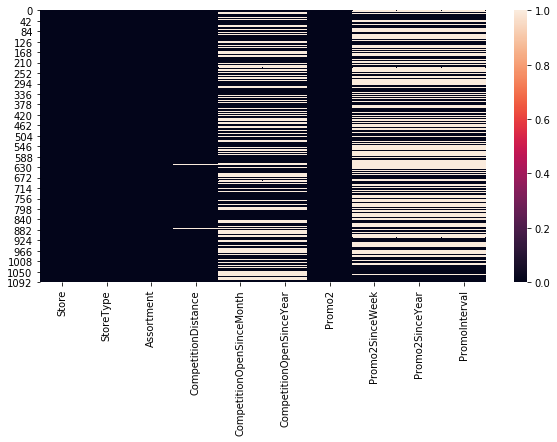

In [141]:
plt.figure(figsize = (10,5))
sns.heatmap(store.isnull());

Checking the missing data:

**We have few variables with missing values that we need to deal with. Let's start with the CompetitionDistance.**

In [142]:
store[store['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).

In [143]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

Continuing further with missing data

In [144]:
# no promo = no information about the promo .. LEts check
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

No, if there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, CompetitionOpenSinceMonth and CompetitionOpenSinceYear.

In [145]:
store[store['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1.07,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,0.31,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3.27,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3.24,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1.04,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1.13,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,0.54,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9.26,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,0.87,NaN,NaN,0,NaN,NaN,NaN


In [146]:
store[store['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1.07,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,0.31,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3.27,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3.24,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1.04,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1.13,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,0.54,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9.26,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,0.87,NaN,NaN,0,NaN,NaN,NaN


In [147]:
store[store['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1.07,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,0.31,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3.27,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3.24,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1.04,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1.13,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,0.54,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9.26,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,0.87,NaN,NaN,0,NaN,NaN,NaN


In [148]:
store[store['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1.27,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,0.62,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29.91,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,0.31,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24.00,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,0.54,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,0.90,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1.88,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9.26,NaN,NaN,0,NaN,NaN,NaN


**Filling the missing numbers:
We have missing numbers in variables related to dates (weeks, years), so we have discrete points instead of a continuous variable that could have missing numbers filled by the mean, for example.**

In [149]:
miss_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
            'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
for str in miss_cols:
  store[str].fillna(0, inplace=True)

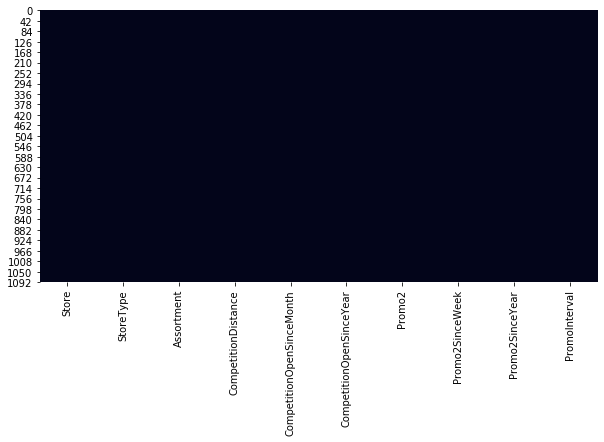

In [150]:
plt.figure(figsize = (10,5))
sns.heatmap(store.isnull(), cbar = False);

Now we do not have null data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021473583048>,
      dtype=object)

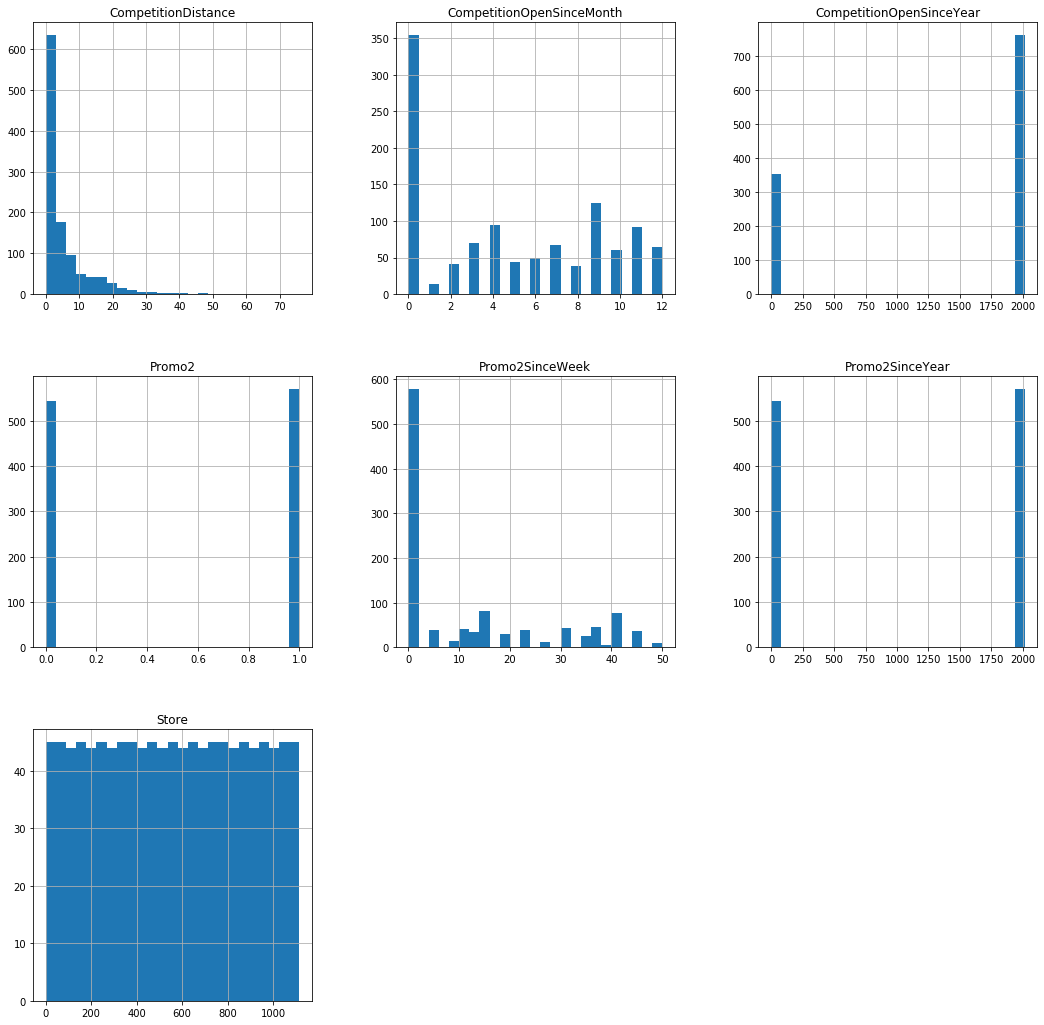

In [151]:
store.hist(bins = 25, figsize=(18,18))

**Main points from this data:**
- Most of the store's competitors are within 10 km distance
- Around half of the stores take part in the aditional sales campaign

**Merging the dataframes Store and Train**

We will use the store id ('Store' column) as a common variable between both dataframes

In [152]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
# refresh the usage of pd.merge
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 23)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1.27,9.0,2008.0,0,0.0,0.0,0


In [153]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 23 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null datetime64[ns]
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
Year                         844338 non-null int64
Month                        844338 non-null int64
Day                          844338 non-null int64
WeekOfYear                   844338 non-null int64
SalePerCustomer              844338 non-null float64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
Compet

In [154]:
train_store.shape

(844338, 23)

In [155]:
train_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
SalePerCustomer              0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

**Store types**

In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.



In [156]:
# refresh the usage of df.groupby
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [157]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. 

**As now in dataframe all store are open hence dropping Open column**

In [158]:
train_store.drop(['Open'], axis = 1, inplace=True)


In [159]:
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,2015,7,...,9.482883,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,2015,7,...,9.194139,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,2015,7,...,9.143403,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,2015,7,...,8.948214,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,2015,7,...,9.970588,c,a,1.27,9.0,2008.0,0,0.0,0.0,0


**Now let's visualize the correlations between variables**

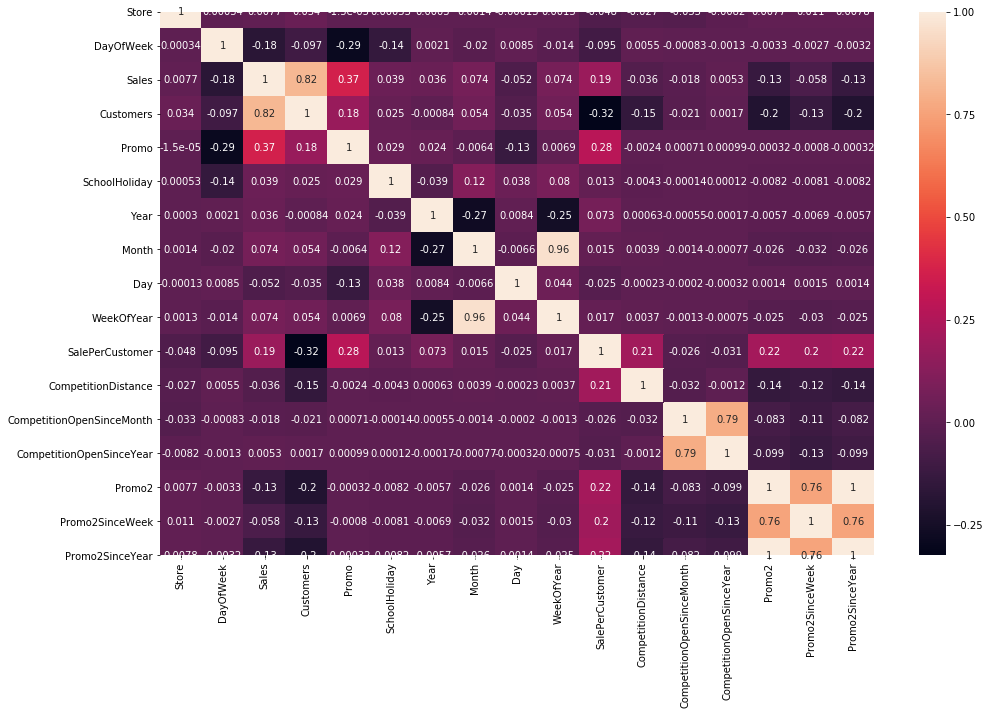

In [160]:
correlations = train_store.corr()
f, ax = plt.subplots(figsize=(16,10))
sns.heatmap(correlations, annot = True);

**Some conclusions from the correlation matrix:**

The obvious correlations are:
- Sales are strongly correlated to the 'customers'variable
- Sales are moderately correlated to the 'promo' variable, meaning that promotions may have an impact on sales but it is not that much strong.

**Some interesting correlations are:**
- Additional promotions (variable 'Promo2') does not have a great impact on the volume of sales as the correlation is of -0.13 Sometimes we may expect that more promotions are what is needed to increase sales but that is not always true.

In [161]:
#Another way to see the correlations, in this case, related to sales. 
correlations = train_store.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.178753
Promo2SinceYear             -0.127581
Promo2                      -0.127556
Promo2SinceWeek             -0.058493
Day                         -0.051865
CompetitionDistance         -0.035908
CompetitionOpenSinceMonth   -0.018369
CompetitionOpenSinceYear     0.005257
Store                        0.007723
Year                         0.036151
SchoolHoliday                0.038635
Month                        0.073589
WeekOfYear                   0.074463
SalePerCustomer              0.186563
Promo                        0.368199
Customers                    0.823552
Sales                        1.000000
Name: Sales, dtype: float64

In [162]:
#Related to number of customers:
correlations2 = train_store.corr()['Customers'].sort_values()
correlations2

SalePerCustomer             -0.323926
Promo2                      -0.202207
Promo2SinceYear             -0.202180
CompetitionDistance         -0.147859
Promo2SinceWeek             -0.130864
DayOfWeek                   -0.097266
Day                         -0.035416
CompetitionOpenSinceMonth   -0.021005
Year                        -0.000842
CompetitionOpenSinceYear     0.001657
SchoolHoliday                0.024915
Store                        0.033991
WeekOfYear                   0.053763
Month                        0.053843
Promo                        0.182859
Sales                        0.823552
Customers                    1.000000
Name: Customers, dtype: float64

#### Checking for outliers

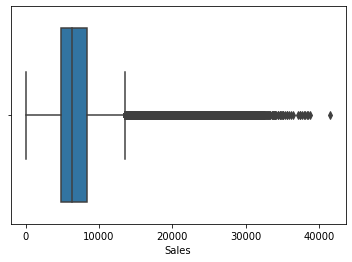

In [163]:
ax = sns.boxplot(x=train_store["Sales"])

**Dropping 99 percentaile outliers**

In [164]:
P = np.percentile(train_store.Sales, [5, 95])
train_store = train_store[(train_store.Sales < P[1])]

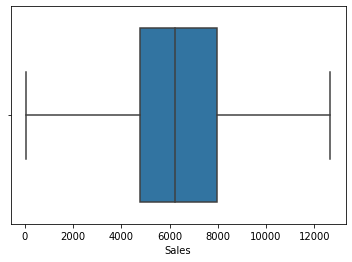

In [165]:
ax = sns.boxplot(x=train_store["Sales"])

In [166]:
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,2015,7,...,9.482883,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,2015,7,...,9.194139,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,2015,7,...,9.143403,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,2015,7,...,8.948214,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,2015,7,...,9.970588,c,a,1.27,9.0,2008.0,0,0.0,0.0,0


In [167]:
train_store.shape

(802107, 22)

### Visualising the data with time series

In [168]:
train_store['Year'] = pd.DatetimeIndex(train_store['Date']).year
train_store['Month'] = pd.DatetimeIndex(train_store['Date']).month
train_store['Day'] = pd.DatetimeIndex(train_store['Date']).day
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,2015,7,...,9.482883,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,2015,7,...,9.194139,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,2015,7,...,9.143403,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,2015,7,...,8.948214,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,2015,7,...,9.970588,c,a,1.27,9.0,2008.0,0,0.0,0.0,0


**Monthly Analysis**

Text(0.5, 1.0, 'Average sales per month')

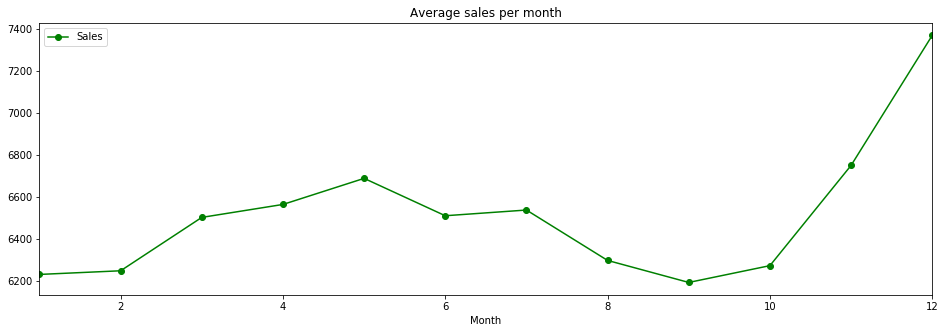

In [169]:
axis = train_store.groupby('Month')[['Sales']].mean().plot(figsize = (16,5), marker = 'o', color = 'g')
axis.set_title('Average sales per month')

Text(0.5, 1.0, 'Average clients per month')

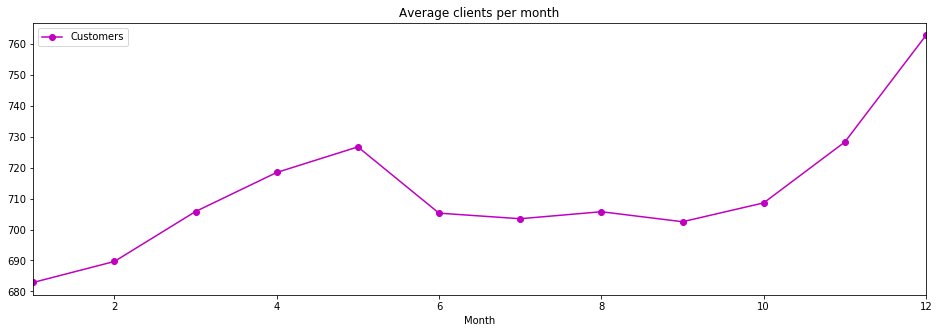

In [170]:
axis = train_store.groupby('Month')[['Customers']].mean().plot(figsize = (16,5), marker = 'o', color = 'm')
axis.set_title('Average clients per month')

- Clearly we can see an influence from Christmas in the the sales, with peak of number of clients in December.
- Another small peak appears around the month of July, when it is summer vacations and probably there are more people going to the shops.
- Around Janurary and February the number of clients is low, and this may be explained by the fact that these are the winter months after christmas.

**Daily Analysis**

Text(0.5, 1.0, 'Average Sales per Day')

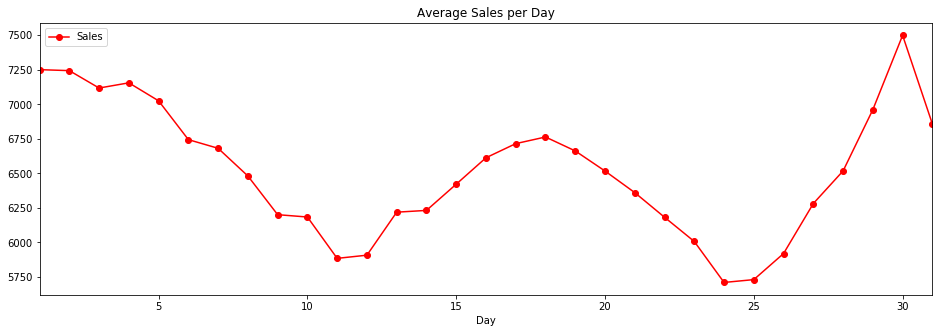

In [171]:
axis = train_store.groupby('Day')[['Sales']].mean().plot(figsize = (16,5), marker = 'o', color = 'r')
axis.set_title('Average Sales per Day')

Text(0.5, 1.0, 'Average clients per day')

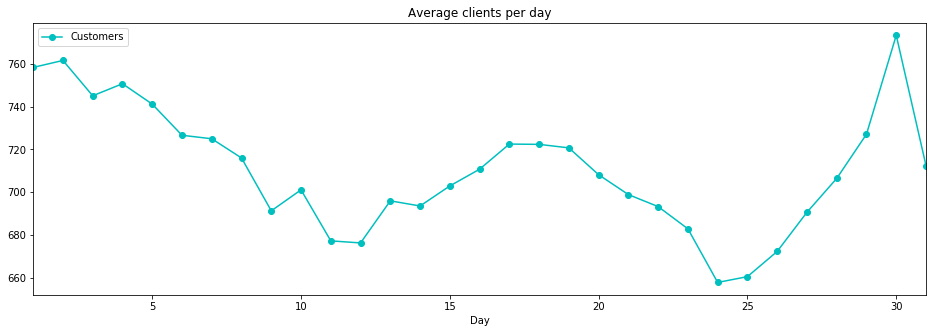

In [172]:
axis = train_store.groupby('Day')[['Customers']].mean().plot(figsize = (16,5), marker = 'o', color = 'c')
axis.set_title('Average clients per day')

**Day of the week analysis**

Text(0.5, 1.0, 'Average sales per day of the week')

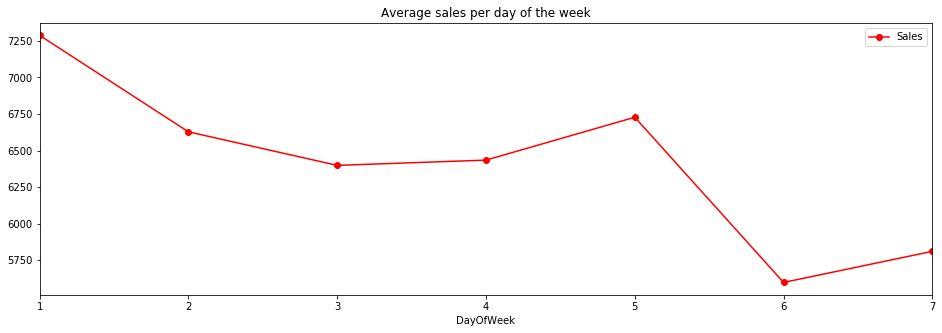

In [173]:
axis = train_store.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (16,5), marker = 'o', color = 'r')
axis.set_title('Average sales per day of the week')

Text(0.5, 1.0, 'Average customers per day of the week')

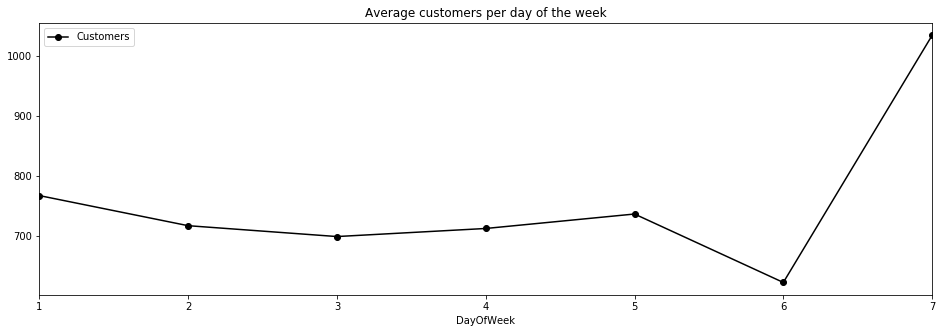

In [174]:
axis = train_store.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (16,5), marker = 'o', color = 'k')
axis.set_title('Average customers per day of the week')

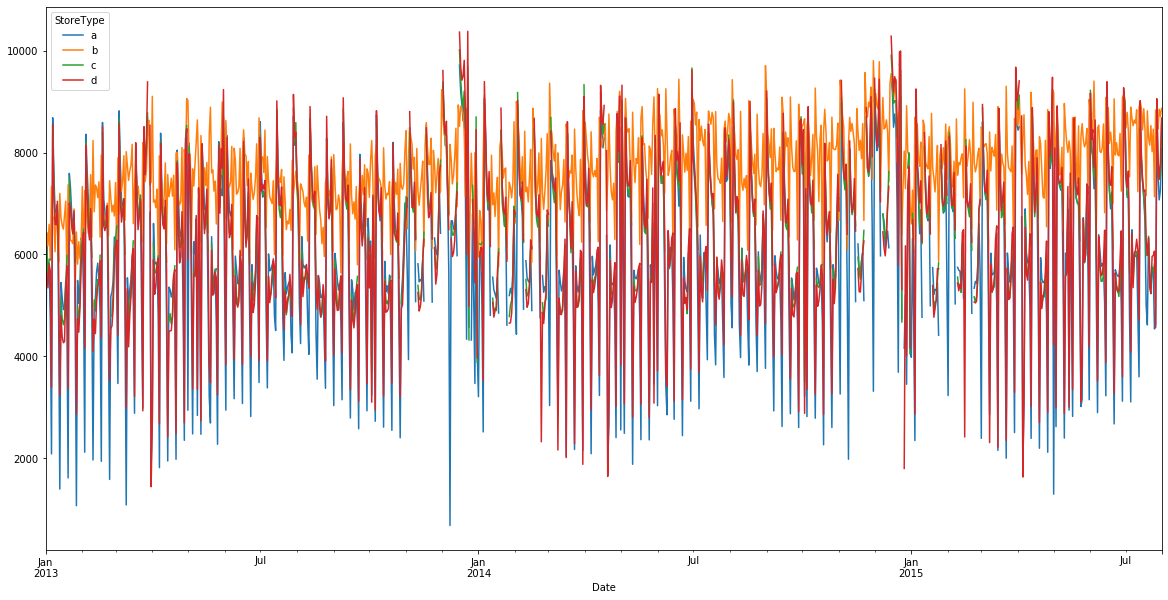

In [175]:
fig, ax = plt.subplots(figsize = (20,10))
train_store.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax);

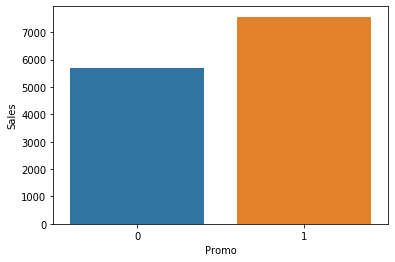

In [176]:
sns.barplot(x = 'Promo', y = 'Sales', data = train_store);

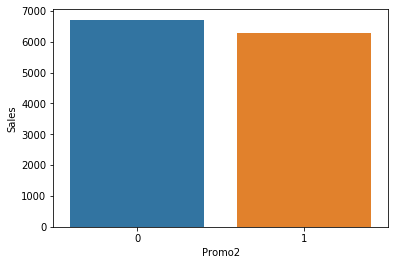

In [177]:
sns.barplot(x = 'Promo2', y = 'Sales', data = train_store);

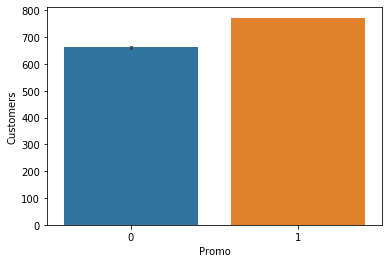

In [178]:
sns.barplot(x = 'Promo', y = 'Customers', data = train_store);

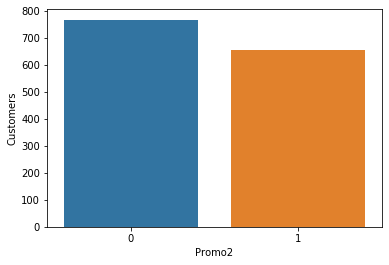

In [179]:
sns.barplot(x = 'Promo2', y = 'Customers', data = train_store);

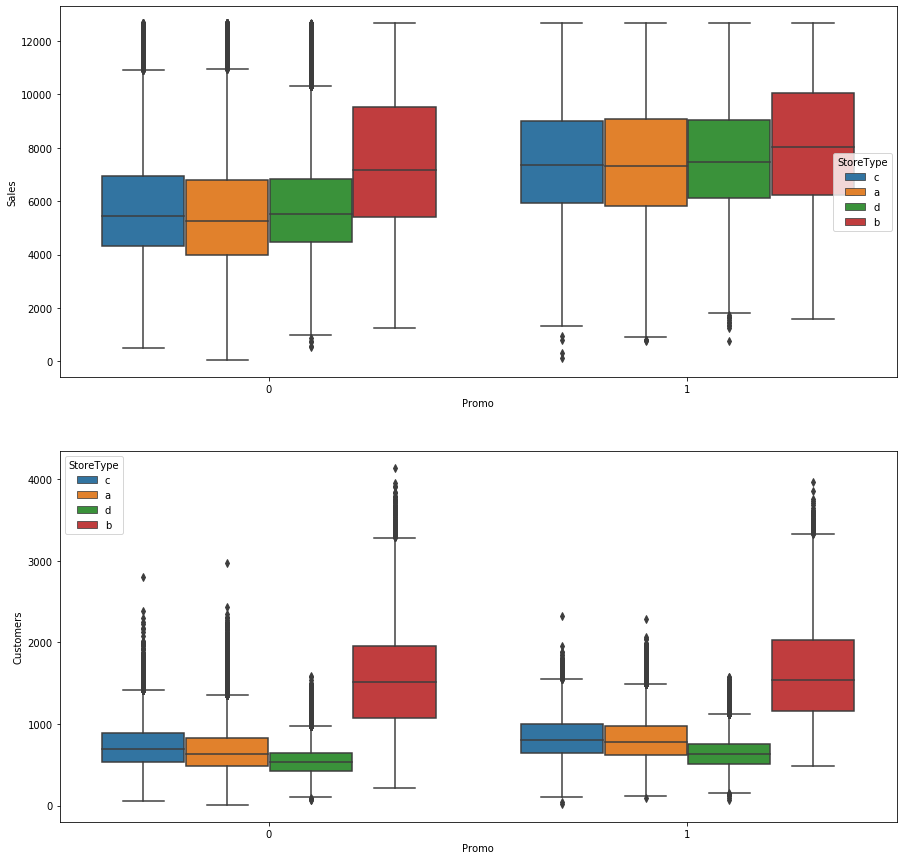

In [180]:
#On average, customers visit and sales are higher during promo. 
plt.figure(figsize = (15,15))

plt.subplot(211)
sns.boxplot(x = 'Promo' , y = 'Sales' ,hue = 'StoreType' ,data = train_store)
plt.subplot(212)
sns.boxplot(x = 'Promo' , y = 'Customers' ,hue = 'StoreType' ,data = train_store)

### Feature Creation / Feature Selection

In [181]:
def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    data['DayOfWeek'] = data.Date.dt.dayofweek
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [182]:
features_create(train_store)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,0,1,2015,7,...,9.0,2008.0,0,0.0,0.0,,82.0,24187.75,Jul,0
1,1,3,2015-07-30,5020,546,1,0,1,2015,7,...,9.0,2008.0,0,0.0,0.0,,82.0,24187.75,Jul,0
2,1,2,2015-07-29,4782,523,1,0,1,2015,7,...,9.0,2008.0,0,0.0,0.0,,82.0,24187.75,Jul,0
3,1,1,2015-07-28,5011,560,1,0,1,2015,7,...,9.0,2008.0,0,0.0,0.0,,82.0,24187.75,Jul,0
4,1,0,2015-07-27,6102,612,1,0,1,2015,7,...,9.0,2008.0,0,0.0,0.0,,82.0,24187.75,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,292,0,2013-01-07,9291,1002,1,0,0,2013,1,...,6.0,2009.0,0,0.0,0.0,,43.0,24156.50,Jan,0
844334,292,5,2013-01-05,2748,340,0,0,0,2013,1,...,6.0,2009.0,0,0.0,0.0,,43.0,24156.25,Jan,0
844335,292,4,2013-01-04,4202,560,0,0,1,2013,1,...,6.0,2009.0,0,0.0,0.0,,43.0,24156.25,Jan,0
844336,292,3,2013-01-03,4580,662,0,0,1,2013,1,...,6.0,2009.0,0,0.0,0.0,,43.0,24156.25,Jan,0


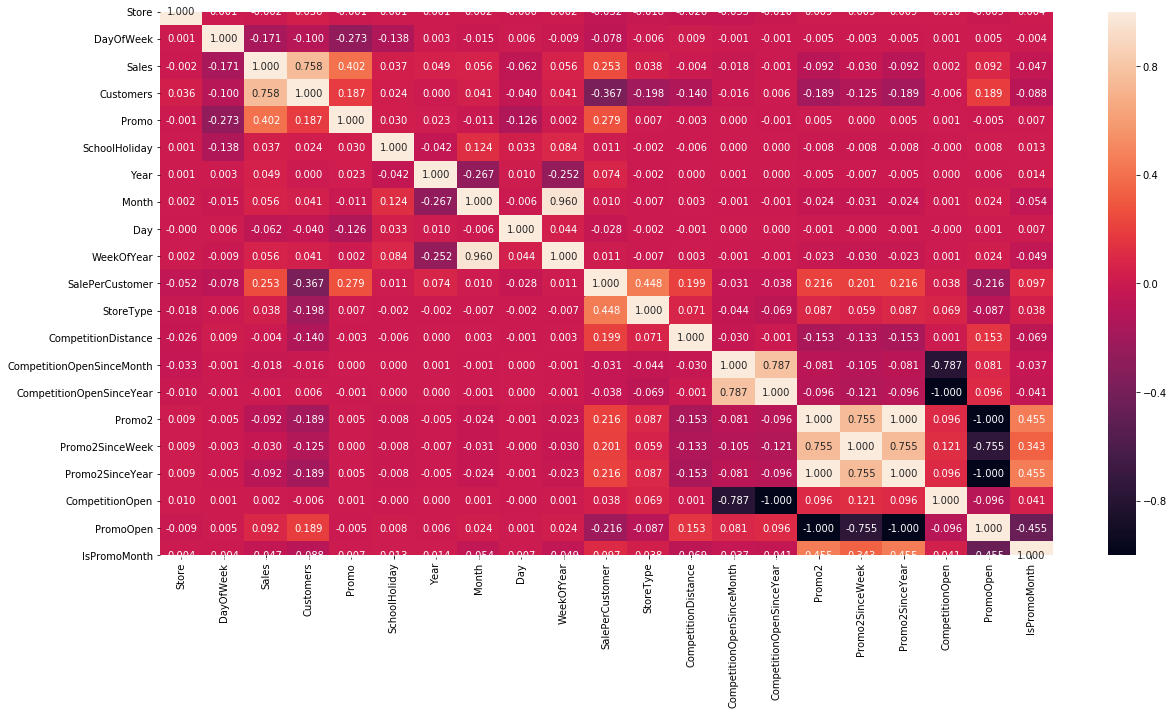

In [183]:
plt.figure(figsize = (20, 10))

sns.heatmap(train_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

We can see that the Customers,promo and Sales/Customers are highly correlated with sales

There are several things here:

- In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.
- On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).
- Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

**Conclusion of EDA**

- The most selling and crowded StoreType is A.
- The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider proposing bigger variety of its products.
- Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small" things. Eventhough this StoreType generated the least amount of sales and customers over the whole period, it shows a great potential.
- Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0).
- Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

### Model Training : 

**Sorting the data based on date**

In [184]:
train_store= train_store.set_index('Date')

In [185]:
train_store = train_store.sort_values('Date')

**Creating new Dataset with store no 1,3,8,9,13,25,29,31 and 46)**

In [186]:
Model_data=train_store.loc[train_store['Store'].isin([1,3,8,9,13,25,29,31,46,85])]

In [187]:
Model_data.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,85,1,4220,619,0,1,1,2013,1,1,...,10.0,2011.0,0,0.0,0.0,,15.0,24156.25,Jan,0
2013-01-02,1,2,5530,668,0,0,1,2013,1,2,...,9.0,2008.0,0,0.0,0.0,,52.0,24156.25,Jan,0
2013-01-02,85,2,6069,914,0,0,1,2013,1,2,...,10.0,2011.0,0,0.0,0.0,,15.0,24156.25,Jan,0
2013-01-02,31,2,5122,567,0,0,1,2013,1,2,...,7.0,2012.0,0,0.0,0.0,,6.0,24156.25,Jan,0
2013-01-02,46,2,4016,582,0,0,1,2013,1,2,...,9.0,2005.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",88.0,20.75,Jan,1


**For Time Series Anlaysis , we consider one store from each store type a , b , c ,d**

In [188]:
Model_data['Sales'] = Model_data['Sales'] * 1.0

 **Time-Series Analysis per Store Type**

In [189]:
sales_a = Model_data[Model_data.Store == 3]['Sales']
sales_b = Model_data[Model_data.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = Model_data[Model_data.Store == 1]['Sales']
sales_d = Model_data[Model_data.Store == 13]['Sales']

In [190]:
Customers_a = Model_data[Model_data.Store == 2]['Customers']
Customers_b = Model_data[Model_data.Store == 85]['Customers'].sort_index(ascending = True) # solve the reverse order
Customers_c = Model_data[Model_data.Store == 1]['Customers']
Customers_d = Model_data[Model_data.Store == 13]['Customers']

In [191]:
Promo_a = Model_data[Model_data.Store == 2]['Promo']
Promo_b = Model_data[Model_data.Store == 85]['Promo'].sort_index(ascending = True) # solve the reverse order
Promo_c = Model_data[Model_data.Store == 1]['Promo']
Promo_d = Model_data[Model_data.Store == 13]['Promo']

**Lets plot the sales of each store on Weekly basis**

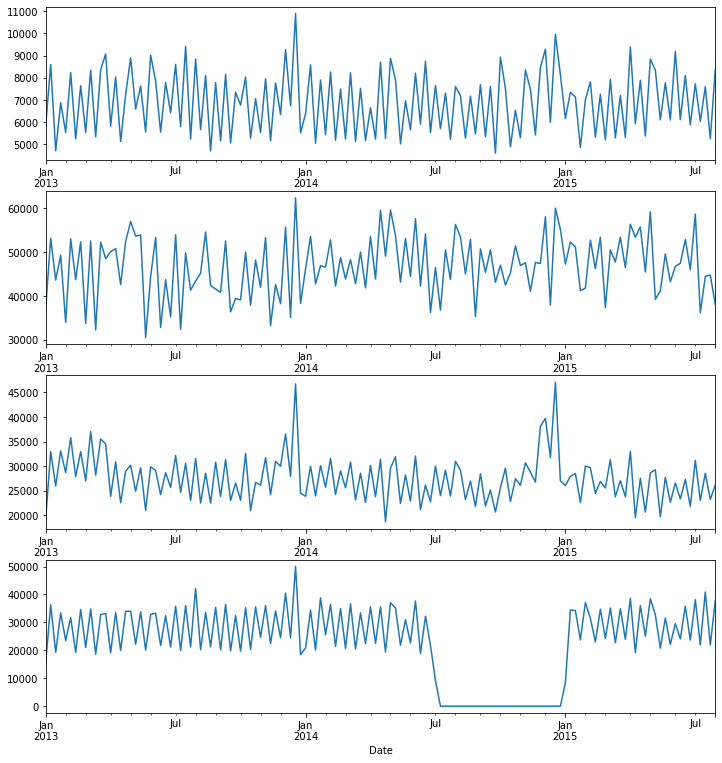

In [192]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').mean().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

**Yearly trend**

The next thing to check the presence of a trend in series.

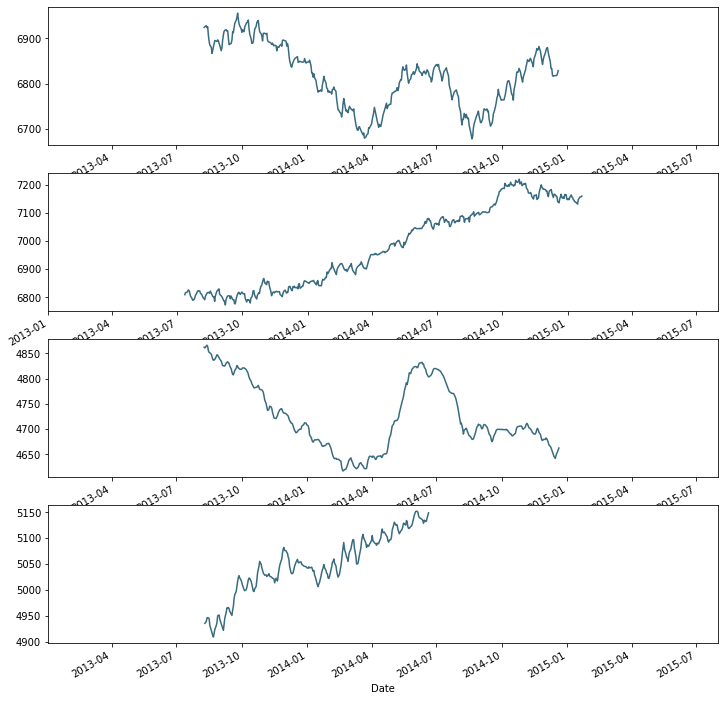

In [193]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

Overall sales seems to increase, however not for the StoreType C (a third from the top). Eventhough the StoreType A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as StoreType C did.

**Autocorrelaion**

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

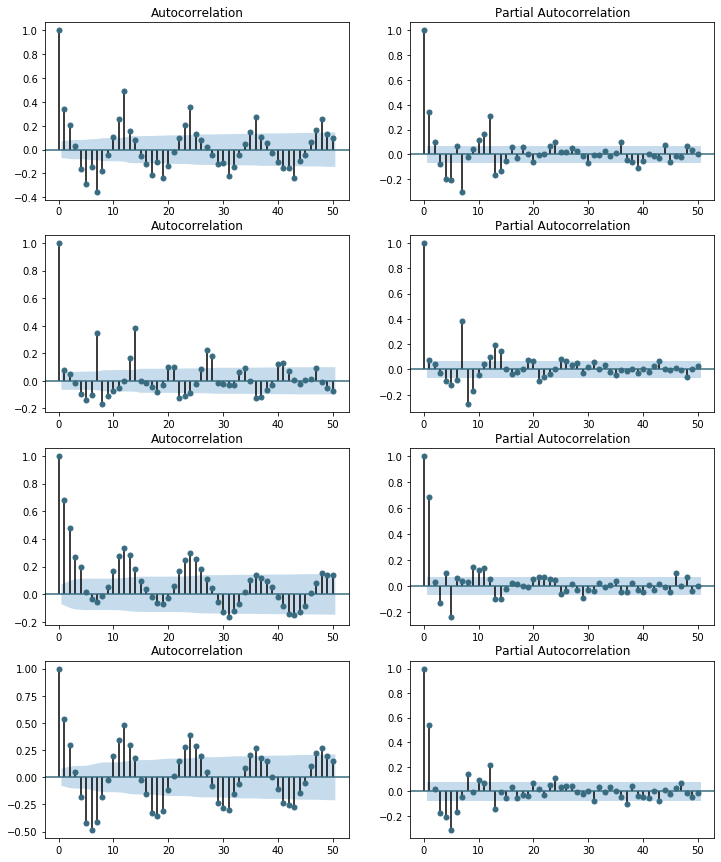

In [194]:
# figure for subplots
plt.figure(figsize = (12, 15))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

- Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
- Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.

**Stationarity of Time Series**

Lets check the stationarity through Dicky-Fulller and Rolling window technique:

We check the trend of sales for 1 store from each StoreType nd plot the data on Weekly basis,we can see that the trend is Stationary .i.e ; Constant mean Constant Variance, Covariance changes with time

**Rolling:** A rolling analysis of a time series model is often used to assess the model's stability over time. When analyzing financial time series data using a statistical model, a key assumption is that the parameters of the model are constant over time.

The window is rolled on Weekly basis , in which the average is taken on weekly basis Rolling Statistics is a visualization test , where we can compare the original data with the rolled data and check if the data is stationary or not

In [195]:
rollmean = sales_a.rolling(window=7).mean()
rollstd = sales_a.rolling(window=7).std()

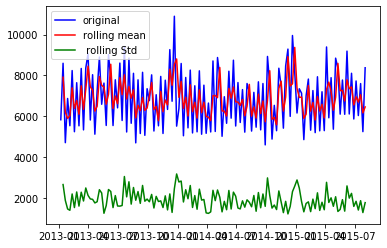

In [196]:
orig = plt.plot(sales_a.resample('W').mean(),color='blue',label='original')
roll_mean = plt.plot(rollmean.resample('W').mean(),color='red',label='rolling mean')
orig_std = plt.plot(rollstd.resample('W').mean(),color='green',label=' rolling Std')
plt.legend(loc='best')
plt.show(block=False)

**Dicky - Fuller test** It is the test which essentially provides the details whether the Null hypothesis(Data is not stationary) should be rejected against alternate hypothesis(Data is stationary) It gives the Statistical measures explaining the ADF-Statistics value which should be less than the critical values we accept / reject the null hypothesis based on the p-value p-value < 0.5 indicates that the null hypothesis should be rejected

Thus from our data it is clear that our data is stationary and doesnot change heavily with time.

**The Akaike information criterion (AIC) :** It is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

ADF statistics should be less than the critical interval

In [197]:
from statsmodels.tsa.stattools import adfuller
def stationary_check(data):
    result = adfuller(data,autolag='AIC')
    print('ADF Statistic: %f' % result[0])    
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

In [198]:
stationary_check(sales_a)
stationary_check(sales_b)
stationary_check(sales_c)
stationary_check(sales_d)

ADF Statistic: -6.518124
p-value: 0.000000
Critical Values:
1% -3.4390409569041207
5% -2.865375732701395
10% -2.568812543748081
ADF Statistic: -5.448216
p-value: 0.000003
Critical Values:
1% -3.4378028154245515
5% -2.864829958032025
10% -2.568521809142562
ADF Statistic: -5.399623
p-value: 0.000003
Critical Values:
1% -3.4389045244994096
5% -2.8653156040031176
10% -2.5687805115003
ADF Statistic: -6.301020
p-value: 0.000000
Critical Values:
1% -3.4411511898545206
5% -2.866305414688104
10% -2.569307861950312


**Stationary test for customers**

In [199]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [200]:
Model_data = Model_data[['Sales','Store','Customers', 'Promo', 'Promo2','SchoolHoliday','DayOfWeek' ]]


In [201]:
Model_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7357 entries, 2013-01-01 to 2015-07-31
Data columns (total 7 columns):
Sales            7357 non-null float64
Store            7357 non-null int64
Customers        7357 non-null int64
Promo            7357 non-null int64
Promo2           7357 non-null int64
SchoolHoliday    7357 non-null int64
DayOfWeek        7357 non-null int64
dtypes: float64(1), int64(6)
memory usage: 459.8 KB


In [202]:
# ADF Test on each column
for name, column in Model_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.3391
 No. Lags Chosen       = 36
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Store" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.5027
 No. Lags Chosen       = 35
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.3118
 No. Lags Chosen       = 23
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 


**Summary:** Series is stationary

**Granger Casuality test**

The null Hypothesis for Granger Casuality test is : HO: There is no casuality between sales and customer

In [203]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(Model_data, variables = Model_data.columns)     

,Sales_x,Store_x,Customers_x,Promo_x,Promo2_x,SchoolHoliday_x,DayOfWeek_x
Sales_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Store_y,0.0067,1.0000,0.0295,0.0000,0.1071,0.0006,0.0000
Customers_y,0.0000,0.0001,1.0000,0.0000,0.0321,0.0004,0.0000
Promo_y,0.0000,0.0000,0.0000,1.0000,0.0050,0.0000,0.0000
Promo2_y,0.2441,0.0585,0.0244,0.0398,1.0000,0.0758,0.0482
SchoolHoliday_y,0.0000,0.0002,0.0000,0.0000,0.0464,1.0000,0.0000
DayOfWeek_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


**Summary :** Store and sales, store and customer, store and School holiday, sales and promo 2 are not causing each other

### Cointegration Test

In [204]:
"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [205]:
joh_model1 = coint_johansen(Model_data[['Sales','Customers','Promo']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat   trace_stat
0   2817.051405  3180.241080
1    304.809203   363.189675
2     58.380471    58.380471 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[15.7175 17.7961 22.2519]
 [ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[21.7781 24.2761 29.5147]
 [10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



Note that the test-statistics at each stage for both trace test and max eigen test are greater than the test statistic at 5% significance level. SO THE RANK OF THE MATRIX IS 2 => NO COINTEGRATION => VAR IN DIFFERENCE IS SUFFICIENT FOR THESE 3 SERIES.

### Split the Series into Training and Testing Data

In [206]:
Model_data1 = Model_data[Model_data.Store == 1].drop(['Store'], axis = 1)
Model_data3 = Model_data[Model_data.Store == 3].drop(['Store'], axis = 1)
Model_data8 = Model_data[Model_data.Store == 8].drop(['Store'], axis = 1)
Model_data9 = Model_data[Model_data.Store == 9].drop(['Store'], axis = 1)
Model_data13 = Model_data[Model_data.Store == 13].drop(['Store'], axis = 1)
Model_data25 = Model_data[Model_data.Store == 25].drop(['Store'], axis = 1)
Model_data29 = Model_data[Model_data.Store == 29].drop(['Store'], axis = 1)
Model_data31 = Model_data[Model_data.Store == 31].drop(['Store'], axis = 1)
Model_data46 = Model_data[Model_data.Store == 46].drop(['Store'], axis = 1)

In [207]:
Model_data1.shape

(781, 6)

In [208]:
nobs = 40
Model_train1, Model_test1 = Model_data1[0:-nobs], Model_data1[-nobs:]
Model_train3, Model_test3 = Model_data3[0:-nobs], Model_data3[-nobs:]
Model_train8, Model_test8 = Model_data8[0:-nobs], Model_data8[-nobs:]
Model_train9, Model_test9 = Model_data9[0:-nobs], Model_data9[-nobs:]
Model_train25, Model_test25 = Model_data25[0:-nobs], Model_data25[-nobs:]
Model_train29, Model_test29 = Model_data29[0:-nobs], Model_data29[-nobs:]
Model_train31, Model_test31 = Model_data31[0:-nobs], Model_data31[-nobs:]
Model_train46, Model_test46 = Model_data46[0:-nobs], Model_data46[-nobs:]
Model_train13, Model_test13 = Model_data13[0:-nobs], Model_data13[-nobs:]

In [209]:
Model_train_endog1 = Model_train1[['Sales', 'Customers']]
Model_test_endog1 = Model_test1[['Sales', 'Customers']]
Model_train_exog1 = Model_train1[['Sales', 'Customers', 'Promo']]
Model_test_exog1 = Model_test1[['Sales', 'Customers', 'Promo']]

Model_train_endog3 = Model_train3[['Sales', 'Customers']]
Model_test_endog3 = Model_test3[['Sales', 'Customers']]
Model_train_exog3 = Model_train3[['Sales', 'Customers', 'Promo']]
Model_test_exog3 = Model_test3[['Sales', 'Customers', 'Promo']]

Model_train_endog8 = Model_train8[['Sales', 'Customers']]
Model_test_endog8 = Model_test8[['Sales', 'Customers']]
Model_train_exog8 = Model_train8[['Sales', 'Customers', 'Promo']]
Model_test_exog8 = Model_test8[['Sales', 'Customers', 'Promo']]

Model_train_endog9 = Model_train9[['Sales', 'Customers']]
Model_test_endog9 = Model_test9[['Sales', 'Customers']]
Model_train_exog9 = Model_train9[['Sales', 'Customers', 'Promo']]
Model_test_exog9 = Model_test9[['Sales', 'Customers', 'Promo']]

Model_train_endog13 = Model_train13[['Sales', 'Customers']]
Model_test_endog13 = Model_test13[['Sales', 'Customers']]
Model_train_exog13 = Model_train13[['Sales', 'Customers', 'Promo']]
Model_test_exog13 = Model_test13[['Sales', 'Customers', 'Promo']]

Model_train_endog25 = Model_train25[['Sales', 'Customers']]
Model_test_endog25 = Model_test25[['Sales', 'Customers']]
Model_train_exog25 = Model_train25[['Sales', 'Customers', 'Promo']]
Model_test_exog25 = Model_test25[['Sales', 'Customers', 'Promo']]

Model_train_endog29 = Model_train29[['Sales', 'Customers']]
Model_test_endog29 = Model_test29[['Sales', 'Customers']]
Model_train_exog29 = Model_train29[['Sales', 'Customers', 'Promo']]
Model_test_exog29 = Model_test29[['Sales', 'Customers', 'Promo']]

Model_train_endog31 = Model_train31[['Sales', 'Customers']]
Model_test_endog31 = Model_test31[['Sales', 'Customers']]
Model_train_exog31 = Model_train31[['Sales', 'Customers', 'Promo']]
Model_test_exog31 = Model_test31[['Sales', 'Customers', 'Promo']]

Model_train_endog46 = Model_train46[['Sales', 'Customers']]
Model_test_endog46 = Model_test46[['Sales', 'Customers']]
Model_train_exog46 = Model_train46[['Sales', 'Customers', 'Promo']]
Model_test_exog46 = Model_test46[['Sales', 'Customers', 'Promo']]

### VAR Model

In [210]:
from statsmodels.tsa.api import VAR
def VARModel(Data):
    model1 = VAR(Data)
    for i in [1,2,3,4,5,6,7,8,9]:
        result = model1.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')

In [211]:
Model_data1

,Sales,Customers,Promo,Promo2,SchoolHoliday,DayOfWeek
Date,,,,,,
2013-01-02,5530.0,668,0,0,1,2
2013-01-03,4327.0,578,0,0,1,3
2013-01-04,4486.0,619,0,0,1,4
2013-01-05,4997.0,635,0,0,1,5
2013-01-07,7176.0,785,1,0,1,0
...,...,...,...,...,...,...
2015-07-27,6102.0,612,1,0,1,0
2015-07-28,5011.0,560,1,0,1,1
2015-07-29,4782.0,523,1,0,1,2


### Store 1 Model and Forecast

In [212]:
model1 = VAR(Model_train_endog1)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  20.06043874010634
BIC :  20.097789957832273
FPE :  515392255.0209801
HQIC:  20.07483998463136 

Lag Order = 2
AIC :  20.036028504846954
BIC :  20.098346474007283
FPE :  502963880.74684817
HQIC:  20.06005751817101 

Lag Order = 3
AIC :  19.980420429131826
BIC :  20.067758116861377
FPE :  475758802.8109279
HQIC:  20.014098852645485 

Lag Order = 4
AIC :  19.923547029740543
BIC :  20.03595758884422
FPE :  449456421.3643872
HQIC:  19.96689658248686 

Lag Order = 5
AIC :  19.819831362804333
BIC :  19.957368132657642
FPE :  405177505.67336094
HQIC:  19.87287384185978 

Lag Order = 6
AIC :  19.772630092778126
BIC :  19.935346600233274
FPE :  386498085.1407189
HQIC:  19.835387373635868 

Lag Order = 7
AIC :  19.775384876359006
BIC :  19.963334836656603
FPE :  387565823.23369324
HQIC:  19.84787891331459 

Lag Order = 8
AIC :  19.752523942222556
BIC :  19.965761259908973
FPE :  378808205.4389086
HQIC:  19.83477676876198 

Lag Order = 9
AIC :  19.75459442554901
BIC :  19.9931

In the above output, the AIC drops to lowest at lag 6, then increases at lag 7 and then continuously drops further.

Let’s go with the lag 6 model.

**Train the VAR Model of Selected Order(p)**

In [213]:
model_fitted1 = model1.fit(6)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:01:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.9353
Nobs:                     735.000    HQIC:                   19.8354
Log likelihood:          -9326.28    FPE:                3.86498e+08
AIC:                      19.7726    Det(Omega_mle):     3.73180e+08
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              803.974028       225.425712            3.566           0.000
L1.Sales             0.628018         0.085659            7.332           0.000
L1.Customers         0.341060         0.902251            0.378 

In [214]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog1.values[-lag_order:]
forecast_input1

6


array([[4364.,  500.],
       [6102.,  612.],
       [5011.,  560.],
       [4782.,  523.],
       [5020.,  546.],
       [5263.,  555.]])

In [215]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog1.index[-nobs:], columns=Model_test_endog1.columns + '_2d')


In [216]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog1.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)
 
model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'Store']=1
model_comparison.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog1.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)
 
append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=1
append.loc[0,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog1.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog1.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison.loc[model_comparison['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog1.Customers-df_forecast1.Customers_2d)
actual = df_forecast1.Customers_2d
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison.loc[model_comparison['Variable']=='Customers', 'MAPE'] = mape

In [226]:
model_comparison.reset_index(drop=True, inplace=True)
Model_final =model_comparison
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37


### VARMAX Model

In [218]:
exog = Model_train_exog1['Promo']
mod = sm.tsa.VARMAX(Model_train_endog1, order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  741
Model:                        VARMAX(1,1)   Log Likelihood               -9401.732
                              + intercept   AIC                          18833.464
Date:                    Mon, 05 Apr 2021   BIC                          18902.584
Time:                            22:01:35   HQIC                         18860.112
Sample:                                 0                                         
                                    - 741                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              178.47, 396.02   Jarque-Bera (JB):        646.81, 36.07
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.55, 0.94   Skew:                       0.09, 0.06
P

In [219]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog1[['Promo']] )

In [220]:
f_fst1 = y_fcst.values

In [221]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog1.index[-nobs:], columns=Model_test_endog1.columns + '_2d')

In [222]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog1.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_1=pd.DataFrame()
model_comparisonMAX_1.loc[0,'Model']='VARMAX'
model_comparisonMAX_1.loc[0,'Variable']='Sales'
model_comparisonMAX_1.loc[0,'Store']=1
model_comparisonMAX_1.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog1.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=1
append.loc[0,'RMSE']=rmse

model_comparisonMAX_1 = model_comparisonMAX_1.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog1.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog1.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_1.loc[model_comparisonMAX_1['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog1.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog1.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_1.loc[model_comparisonMAX_1['Variable']=='Customers', 'MAPE'] = mape

In [223]:
model_comparisonMAX_1.reset_index(drop=True, inplace=True)
model_comparisonMAX_1

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87


In [227]:
Model_final = Model_final.append(model_comparisonMAX_1)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87


### Impulse Response Function

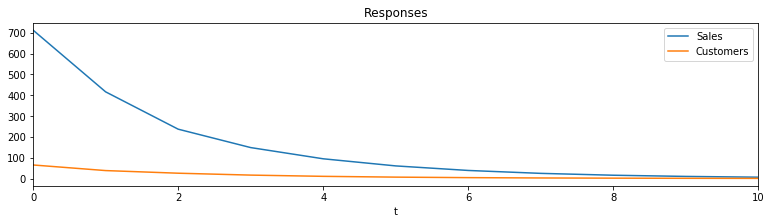

In [228]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Store 3 Model

In [229]:
model1 = VAR(Model_train_endog3)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  22.763954497781263
BIC :  22.80170554874682
FPE :  7695907956.492999
HQIC:  22.778519131779124 

Lag Order = 2
AIC :  22.761745788506182
BIC :  22.82473171075596
FPE :  7678931284.156299
HQIC:  22.786047771958714 

Lag Order = 3
AIC :  22.729589741491754
BIC :  22.817864761649382
FPE :  7435940661.554466
HQIC:  22.763651242647526 

Lag Order = 4
AIC :  22.693793400745225
BIC :  22.807411938015658
FPE :  7174478626.408909
HQIC:  22.73763666842908 

Lag Order = 5
AIC :  22.530093062382896
BIC :  22.669109729498796
FPE :  6091119335.838377
HQIC:  22.583740426396346 

Lag Order = 6
AIC :  22.293928040260102
BIC :  22.4583976444342
FPE :  4809869206.536219
HQIC:  22.35740191178429 

Lag Order = 7
AIC :  22.264245501830807
BIC :  22.454223045714194
FPE :  4669217625.065051
HQIC:  22.337568373831992 

Lag Order = 8
AIC :  22.264193978234797
BIC :  22.479734660881267
FPE :  4669002632.974428
HQIC:  22.34738842587239 

Lag Order = 9
AIC :  22.267701532637336
BIC :  22.50886

In the above output, the AIC drops to lowest at lag 6, then increases at lag 7 and then continuously drops further.

Let’s go with the lag 6 model.

**Train the VAR Model of Selected Order(p)**

In [230]:
model_fitted1 = model1.fit(6)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:03:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    22.4584
Nobs:                     725.000    HQIC:                   22.3574
Log likelihood:          -10113.0    FPE:                4.80987e+09
AIC:                      22.2939    Det(Omega_mle):     4.64191e+09
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             4219.167877       741.123607            5.693           0.000
L1.Sales             1.293797         0.109402           11.826           0.000
L1.Customers       -14.213883         1.227458          -11.580 

In [231]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog3.values[-lag_order:]
forecast_input1

6


array([[3878.,  412.],
       [8107.,  768.],
       [8864.,  818.],
       [7610.,  716.],
       [8977.,  823.],
       [8314.,  821.]])

In [232]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog3.index[-nobs:], columns=Model_test_endog3.columns + '_2d')


In [233]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog3.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison3=pd.DataFrame()
model_comparison3.loc[0,'Model']='VAR'
model_comparison3.loc[0,'Variable']='Sales'
model_comparison3.loc[0,'Store']=3
model_comparison3.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog3.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=3
append.loc[0,'RMSE']=rmse

model_comparison3 = model_comparison3.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog3.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog3.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison3.loc[model_comparison3['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog3.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog3.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison3.loc[model_comparison3['Variable']=='Customers', 'MAPE'] = mape

In [234]:
model_comparison3.reset_index(drop=True, inplace=True)
model_comparison3

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30


In [235]:
Model_final = Model_final.append(model_comparison3)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30


### VARMAX Model

In [236]:
exog = Model_train_exog3['Promo']
mod = sm.tsa.VARMAX(Model_train_exog3[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  731
Model:                        VARMAX(1,1)   Log Likelihood              -10148.873
                              + intercept   AIC                          20327.745
Date:                    Mon, 05 Apr 2021   BIC                          20396.661
Time:                            22:04:14   HQIC                         20354.332
Sample:                                 0                                         
                                    - 731                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              200.32, 294.67   Jarque-Bera (JB):         68.88, 35.26
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.97, 1.22   Skew:                      0.55, -0.51
P

In [237]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog3[['Promo']] )

In [238]:
f_fst1 = y_fcst.values

In [239]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog3.index[-nobs:], columns=Model_test_endog3.columns + '_2d')

In [240]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog3.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_3=pd.DataFrame()
model_comparisonMAX_3.loc[0,'Model']='VARMAX'
model_comparisonMAX_3.loc[0,'Variable']='Sales'
model_comparisonMAX_3.loc[0,'Store']=3
model_comparisonMAX_3.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog3.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=3
append.loc[0,'RMSE']=rmse

model_comparisonMAX_3 = model_comparisonMAX_3.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog3.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog3.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_3.loc[model_comparisonMAX_3['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog3.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog3.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_3.loc[model_comparisonMAX_3['Variable']=='Customers', 'MAPE'] = mape

In [241]:
model_comparisonMAX_3.reset_index(drop=True, inplace=True)
model_comparisonMAX_3

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20


In [243]:
Model_final = Model_final.append(model_comparisonMAX_3)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20


#### Impulse Response Function

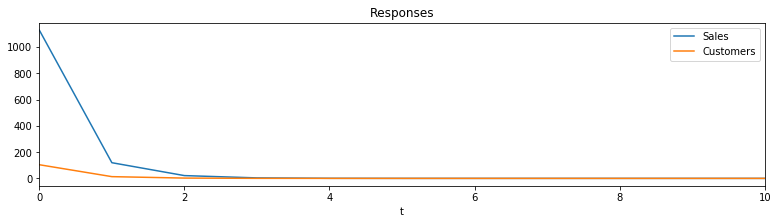

In [244]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Store 8 Model

In [245]:
model1 = VAR(Model_train_endog8)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  22.745949864382233
BIC :  22.783182941459362
FPE :  7558585845.380476
HQIC:  22.760302848771346 

Lag Order = 2
AIC :  22.567723939328015
BIC :  22.629844549074203
FPE :  6324674117.561087
HQIC:  22.591672327432168 

Lag Order = 3
AIC :  22.459977383127676
BIC :  22.547038123686576
FPE :  5678645126.840287
HQIC:  22.49354266202603 

Lag Order = 4
AIC :  22.29244239156812
BIC :  22.404496044745915
FPE :  4802703331.816272
HQIC:  22.335646125143185 

Lag Order = 5
AIC :  22.139296275442724
BIC :  22.276395807595446
FPE :  4120748560.7258096
HQIC:  22.192160104755654 

Lag Order = 6
AIC :  21.643441088207364
BIC :  21.805639651133667
FPE :  2509748478.7991405
HQIC:  21.705986731875587 

Lag Order = 7
AIC :  21.6262985239191
BIC :  21.813649455758558
FPE :  2467101379.383001
HQIC:  21.698547778496295 

Lag Order = 8
AIC :  21.576250776845722
BIC :  21.788807602982654
FPE :  2346679559.7753067
HQIC:  21.658225517204137 

Lag Order = 9
AIC :  21.584259051774673
BIC :  21

In the above output, the AIC drops to lowest at lag 8
Let’s go with the lag 8 model.

**Train the VAR Model of Selected Order(p)**

In [246]:
model_fitted1 = model1.fit(8)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:04:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.7888
Nobs:                     736.000    HQIC:                   21.6582
Log likelihood:          -9994.74    FPE:                2.34668e+09
AIC:                      21.5763    Det(Omega_mle):     2.24192e+09
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             1551.048864       685.573104            2.262           0.024
L1.Sales             0.928387         0.102829            9.028           0.000
L1.Customers        -9.317656         1.126447           -8.272 

In [247]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog8.values[-lag_order:]
forecast_input1

8


array([[6109.,  783.],
       [4917.,  558.],
       [3288.,  398.],
       [8739.,  841.],
       [6717.,  695.],
       [7029.,  698.],
       [8420.,  882.],
       [8492.,  833.]])

In [248]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog8.index[-nobs:], columns=Model_test_endog8.columns + '_2d')


In [249]:
type(df_forecast1.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [250]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog8.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison8=pd.DataFrame()
model_comparison8.loc[0,'Model']='VAR'
model_comparison8.loc[0,'Variable']='Sales'
model_comparison8.loc[0,'Store']=8
model_comparison8.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog8.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=8
append.loc[0,'RMSE']=rmse

model_comparison8 = model_comparison8.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog8.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog8.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison8.loc[model_comparison8['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog8.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog8.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison8.loc[model_comparison8['Variable']=='Customers', 'MAPE'] = mape

In [251]:
model_comparison8.reset_index(drop=True, inplace=True)
model_comparison8

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


In [252]:
Model_final = Model_final.append(model_comparison8)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


### VARMAX Model

In [253]:
exog = Model_train_exog8['Promo']
mod = sm.tsa.VARMAX(Model_train_exog8[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  744
Model:                        VARMAX(1,1)   Log Likelihood              -10350.437
                              + intercept   AIC                          20730.874
Date:                    Mon, 05 Apr 2021   BIC                          20800.054
Time:                            22:05:43   HQIC                         20757.540
Sample:                                 0                                         
                                    - 744                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              973.98, 604.96   Jarque-Bera (JB):           1.09, 2.07
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.58, 0.36
Heteroskedasticity (H):         1.33, 1.39   Skew:                     -0.09, -0.04
P

In [254]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog8[['Promo']] )

In [255]:
f_fst1 = y_fcst.values

In [256]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog8.index[-nobs:], columns=Model_test_endog8.columns + '_2d')

In [257]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog8.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_8=pd.DataFrame()
model_comparisonMAX_8.loc[0,'Model']='VARMAX'
model_comparisonMAX_8.loc[0,'Variable']='Sales'
model_comparisonMAX_8.loc[0,'Store']=8
model_comparisonMAX_8.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog8.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=8
append.loc[0,'RMSE']=rmse

model_comparisonMAX_8 = model_comparisonMAX_8.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog8.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog8.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_8.loc[model_comparisonMAX_8['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog8.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog8.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_8.loc[model_comparisonMAX_8['Variable']=='Customers', 'MAPE'] = mape

In [258]:
model_comparisonMAX_8.reset_index(drop=True, inplace=True)
model_comparisonMAX_8

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,8.0,1549.09,18.65
1,VARMAX,Customers,8.0,150.47,18.57


In [259]:
Model_final = Model_final.append(model_comparisonMAX_8)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


#### Impulse Response Function

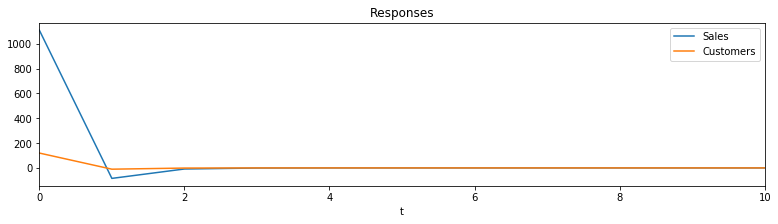

In [260]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Store 9 Model

In [261]:
model1 = VAR(Model_train_endog9)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  20.847659110026786
BIC :  20.8851691381686
FPE :  1132461252.1780293
HQIC:  20.86212524067827 

Lag Order = 2
AIC :  20.79562408685625
BIC :  20.858207358954385
FPE :  1075040859.4711204
HQIC:  20.819761502570767 

Lag Order = 3
AIC :  20.78834204128262
BIC :  20.876052022754827
FPE :  1067241583.9567084
HQIC:  20.82217259186189 

Lag Order = 4
AIC :  20.782638628674874
BIC :  20.89552897333239
FPE :  1061173381.9597368
HQIC:  20.82618424272516 

Lag Order = 5
AIC :  20.742571893452205
BIC :  20.880696444418255
FPE :  1019498237.0021493
HQIC:  20.795854578772854 

Lag Order = 6
AIC :  20.681411535563907
BIC :  20.844824326197962
FPE :  959016689.9764634
HQIC:  20.744453379538378 

Lag Order = 7
AIC :  20.67654874547669
BIC :  20.865304000304462
FPE :  954368397.741244
HQIC:  20.74937191546599 

Lag Order = 8
AIC :  20.673085446296508
BIC :  20.887237581945747
FPE :  951073933.3489647
HQIC:  20.755712190035116 

Lag Order = 9
AIC :  20.661760350302576
BIC :  20.9013

In the above output, the AIC drops to lowest at lag 9

Let’s go with the lag 9 model.

**Train the VAR Model of Selected Order(p)**

In [262]:
model_fitted1 = model1.fit(9)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:06:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.9014
Nobs:                     728.000    HQIC:                   20.7542
Log likelihood:          -9548.86    FPE:                9.40370e+08
AIC:                      20.6618    Det(Omega_mle):     8.93142e+08
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              201.167274       643.366951            0.313           0.755
L1.Sales             0.997448         0.117842            8.464           0.000
L1.Customers        -8.742009         1.807822           -4.836 

In [263]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog9.values[-lag_order:]
forecast_input1

9


array([[ 5649.,   539.],
       [ 6471.,   579.],
       [ 5464.,   546.],
       [ 5330.,   468.],
       [10649.,   777.],
       [ 8751.,   678.],
       [ 7776.,   625.],
       [ 7539.,   651.],
       [ 8565.,   687.]])

In [264]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog9.index[-nobs:], columns=Model_test_endog9.columns + '_2d')


In [265]:
type(df_forecast1.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [266]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog9.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison9=pd.DataFrame()
model_comparison9.loc[0,'Model']='VAR'
model_comparison9.loc[0,'Variable']='Sales'
model_comparison9.loc[0,'Store']=9
model_comparison9.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog9.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=9
append.loc[0,'RMSE']=rmse

model_comparison9 = model_comparison9.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog9.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog8.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison9.loc[model_comparison9['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog9.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog8.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison9.loc[model_comparison9['Variable']=='Customers', 'MAPE'] = mape

In [267]:
model_comparison9.reset_index(drop=True, inplace=True)
model_comparison9

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,9.0,1822.03,18.88
1,VAR,Customers,9.0,95.15,9.72


In [268]:
Model_final = Model_final.append(model_comparison9)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


### VARMAX Model

In [269]:
exog = Model_train_exog8['Promo']
mod = sm.tsa.VARMAX(Model_train_exog8[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  744
Model:                        VARMAX(1,1)   Log Likelihood              -10350.437
                              + intercept   AIC                          20730.874
Date:                    Mon, 05 Apr 2021   BIC                          20800.054
Time:                            22:07:13   HQIC                         20757.540
Sample:                                 0                                         
                                    - 744                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              973.98, 604.96   Jarque-Bera (JB):           1.09, 2.07
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.58, 0.36
Heteroskedasticity (H):         1.33, 1.39   Skew:                     -0.09, -0.04
P

In [270]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog8[['Promo']] )

In [271]:
f_fst1 = y_fcst.values

In [272]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog9.index[-nobs:], columns=Model_test_endog9.columns + '_2d')

In [273]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog9.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_9=pd.DataFrame()
model_comparisonMAX_9.loc[0,'Model']='VARMAX'
model_comparisonMAX_9.loc[0,'Variable']='Sales'
model_comparisonMAX_9.loc[0,'Store']=9
model_comparisonMAX_9.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog9.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=9
append.loc[0,'RMSE']=rmse

model_comparisonMAX_9 = model_comparisonMAX_9.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog9.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog9.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_9.loc[model_comparisonMAX_9['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog9.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog9.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_9.loc[model_comparisonMAX_9['Variable']=='Customers', 'MAPE'] = mape

In [274]:
model_comparisonMAX_9.reset_index(drop=True, inplace=True)
model_comparisonMAX_9

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,9.0,1994.77,22.52
1,VARMAX,Customers,9.0,70.18,10.40


In [275]:
Model_final = Model_final.append(model_comparisonMAX_9)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


#### Impulse Response Function

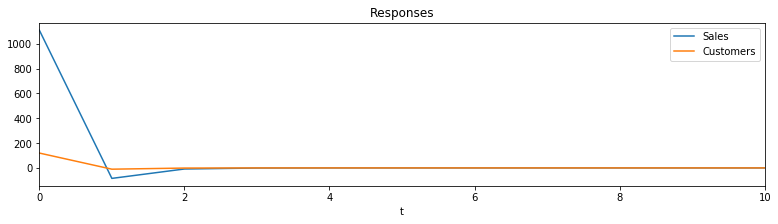

In [276]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Store 13 Model

In [277]:
model1 = VAR(Model_train_endog13)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  20.65769347624957
BIC :  20.70282824973447
FPE :  936531449.0535551
HQIC:  20.675290118614118 

Lag Order = 2
AIC :  20.65139472142808
BIC :  20.72671946197338
FPE :  930651633.6660497
HQIC:  20.680763742100144 

Lag Order = 3
AIC :  20.628849278562566
BIC :  20.7344444933747
FPE :  909905810.4697509
HQIC:  20.670023877962453 

Lag Order = 4
AIC :  20.587892837689775
BIC :  20.723839390197824
FPE :  873394496.9654986
HQIC:  20.640906366158703 

Lag Order = 5
AIC :  20.474081515623904
BIC :  20.64046062766437
FPE :  779443533.2227522
HQIC:  20.53896747435051 

Lag Order = 6
AIC :  20.408382897791
BIC :  20.60527615180966
FPE :  729885558.9037136
HQIC:  20.485174939745104 

Lag Order = 7
AIC :  20.407971368558925
BIC :  20.63546070982998
FPE :  729591373.3355776
HQIC:  20.49670329943263 

Lag Order = 8
AIC :  20.392537455652135
BIC :  20.65070519451479
FPE :  718425301.4366103
HQIC:  20.493243234808325 

Lag Order = 9
AIC :  20.392831322568036
BIC :  20.6817601366806

In the above output, the AIC drops to lowest at lag 9

Let’s go with the lag 9.

**Train the VAR Model of Selected Order(p)**

In [278]:
model_fitted1 = model1.fit(9)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:07:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.6818
Nobs:                     572.000    HQIC:                   20.5055
Log likelihood:          -7417.62    FPE:                7.18647e+08
AIC:                      20.3928    Det(Omega_mle):     6.73182e+08
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             4159.642580       623.756706            6.669           0.000
L1.Sales             0.305378         0.130177            2.346           0.019
L1.Customers         1.558189         2.316918            0.673 

In [279]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog3.values[-lag_order:]
forecast_input1

9


array([[5414.,  607.],
       [5702.,  655.],
       [5080.,  607.],
       [3878.,  412.],
       [8107.,  768.],
       [8864.,  818.],
       [7610.,  716.],
       [8977.,  823.],
       [8314.,  821.]])

In [280]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog13.index[-nobs:], columns=Model_test_endog13.columns + '_2d')


In [281]:
type(df_forecast1.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [282]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog1.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison13=pd.DataFrame()
model_comparison13.loc[0,'Model']='VAR'
model_comparison13.loc[0,'Variable']='Sales'
model_comparison13.loc[0,'Store']=13
model_comparison13.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog13.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=13
append.loc[0,'RMSE']=rmse

model_comparison13 = model_comparison13.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog1.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog13.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison13.loc[model_comparison13['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog13.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog13.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison13.loc[model_comparison13['Variable']=='Customers', 'MAPE'] = mape

In [283]:
model_comparison13.reset_index(drop=True, inplace=True)
model_comparison13

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,13.0,1198.31,23.02
1,VAR,Customers,13.0,117.72,31.27


In [284]:
Model_final = Model_final.append(model_comparison13)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


### VARMAX Model

In [285]:
exog = Model_train_exog13['Promo']
mod = sm.tsa.VARMAX(Model_train_exog13[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  581
Model:                        VARMAX(1,1)   Log Likelihood               -7457.132
                              + intercept   AIC                          14944.264
Date:                    Mon, 05 Apr 2021   BIC                          15009.735
Time:                            22:08:27   HQIC                         14969.787
Sample:                                 0                                         
                                    - 581                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               208.39, 82.26   Jarque-Bera (JB):        217.11, 80.92
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.15, 1.59   Skew:                      1.08, -0.13
P

In [286]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog13[['Promo']] )

In [287]:
f_fst1 = y_fcst.values

In [288]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog13.index[-nobs:], columns=Model_test_endog13.columns + '_2d')

In [289]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog13.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_13=pd.DataFrame()
model_comparisonMAX_13.loc[0,'Model']='VARMAX'
model_comparisonMAX_13.loc[0,'Variable']='Sales'
model_comparisonMAX_13.loc[0,'Store']=13
model_comparisonMAX_13.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog13.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=13
append.loc[0,'RMSE']=rmse

model_comparisonMAX_13 = model_comparisonMAX_13.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog13.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog13.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_13.loc[model_comparisonMAX_13['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog13.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog13.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_13.loc[model_comparisonMAX_13['Variable']=='Customers', 'MAPE'] = mape

In [290]:
model_comparisonMAX_13.reset_index(drop=True, inplace=True)
model_comparisonMAX_13

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,13.0,1269.34,16.45
1,VARMAX,Customers,13.0,51.30,12.50


In [291]:
Model_final = Model_final.append(model_comparisonMAX_13)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


#### Impulse Response Function

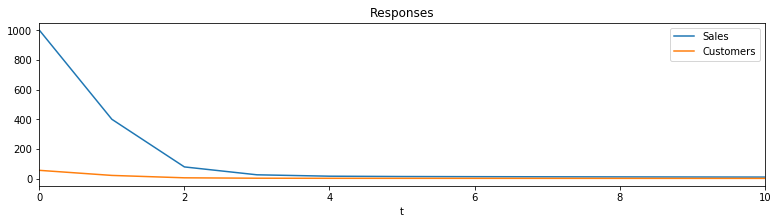

In [292]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Store 25 Model

In [293]:
model1 = VAR(Model_train_endog25)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  23.05873102292266
BIC :  23.107958535381265
FPE :  10334268843.79352
HQIC:  23.07801853263313 

Lag Order = 2
AIC :  23.050829812088434
BIC :  23.132996985676606
FPE :  10252947049.590147
HQIC:  23.083025876871066 

Lag Order = 3
AIC :  22.97971744680947
BIC :  23.09492189393494
FPE :  9549176677.541096
HQIC:  23.024862473669327 

Lag Order = 4
AIC :  22.985352499634175
BIC :  23.133692313637955
FPE :  9603175068.873356
HQIC:  23.043487098380307 

Lag Order = 5
AIC :  22.98400065336608
BIC :  23.165574411809686
FPE :  9590258930.30803
HQIC:  23.055165638005118 

Lag Order = 6
AIC :  22.965896208533504
BIC :  23.18080297651487
FPE :  9418276196.125837
HQIC:  23.050132598675376 

Lag Order = 7
AIC :  22.95840147969425
BIC :  23.206740813192656
FPE :  9348063295.154846
HQIC:  23.055750501970174 

Lag Order = 8
AIC :  22.949597841125197
BIC :  23.23146979037554
FPE :  9266271897.857946
HQIC:  23.060100930618088 

Lag Order = 9
AIC :  22.9406371336946
BIC :  23.25614224

In the above output, the AIC drops to lowest at lag 9

Let’s go with the lag 9.

**Train the VAR Model of Selected Order(p)**

In [294]:
model_fitted1 = model1.fit(9)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:10:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    23.2561
Nobs:                     510.000    HQIC:                   23.0643
Log likelihood:          -7259.18    FPE:                9.18379e+09
AIC:                      22.9406    Det(Omega_mle):     8.53593e+09
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             6346.902321      1038.332444            6.113           0.000
L1.Sales             0.537145         0.143347            3.747           0.000
L1.Customers        -3.235629         1.107474           -2.922 

In [295]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog25.values[-lag_order:]
forecast_input1

9


array([[ 8718.,  1279.],
       [ 9047.,  1147.],
       [ 8323.,  1224.],
       [ 7165.,  1120.],
       [ 7285.,  1004.],
       [11806.,  1536.],
       [10865.,  1363.],
       [10527.,  1254.],
       [11272.,  1422.]])

In [296]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog25.index[-nobs:], columns=Model_test_endog25.columns + '_2d')


In [297]:
type(df_forecast1.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [298]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog25.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison25=pd.DataFrame()
model_comparison25.loc[0,'Model']='VAR'
model_comparison25.loc[0,'Variable']='Sales'
model_comparison25.loc[0,'Store']=25
model_comparison25.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog25.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=25
append.loc[0,'RMSE']=rmse

model_comparison25 = model_comparison25.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog25.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog25.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison25.loc[model_comparison25['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog25.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog25.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison25.loc[model_comparison25['Variable']=='Customers', 'MAPE'] = mape

In [299]:
model_comparison25.reset_index(drop=True, inplace=True)
model_comparison25

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,25.0,1726.02,13.84
1,VAR,Customers,25.0,189.37,11.72


In [300]:
Model_final = Model_final.append(model_comparison25)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


### VARMAX Model

In [301]:
exog = Model_train_exog25['Promo']
mod = sm.tsa.VARMAX(Model_train_exog25[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  519
Model:                        VARMAX(1,1)   Log Likelihood               -7377.747
                              + intercept   AIC                          14785.494
Date:                    Mon, 05 Apr 2021   BIC                          14849.273
Time:                            22:11:21   HQIC                         14810.481
Sample:                                 0                                         
                                    - 519                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                65.75, 79.32   Jarque-Bera (JB):        354.61, 16.97
Prob(Q):                        0.01, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.88, 1.17   Skew:                     -0.98, -0.20
P

In [302]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog25[['Promo']] )

In [303]:
f_fst1 = y_fcst.values

In [304]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog25.index[-nobs:], columns=Model_test_endog25.columns + '_2d')

In [305]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog25.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_25=pd.DataFrame()
model_comparisonMAX_25.loc[0,'Model']='VARMAX'
model_comparisonMAX_25.loc[0,'Variable']='Sales'
model_comparisonMAX_25.loc[0,'Store']=25
model_comparisonMAX_25.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog25.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=25
append.loc[0,'RMSE']=rmse

model_comparisonMAX_25 = model_comparisonMAX_25.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog25.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog25.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_25.loc[model_comparisonMAX_25['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog25.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog25.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_25.loc[model_comparisonMAX_25['Variable']=='Customers', 'MAPE'] = mape

In [306]:
model_comparisonMAX_25.reset_index(drop=True, inplace=True)
model_comparisonMAX_25

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,25.0,1155.36,9.61
1,VARMAX,Customers,25.0,172.50,10.85


In [307]:
Model_final = Model_final.append(model_comparisonMAX_25)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


#### Impulse Response Function

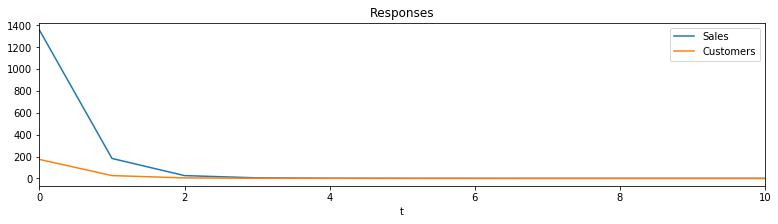

In [308]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Model Store 29

In [309]:
model1 = VAR(Model_train_endog29)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  21.355069092516594
BIC :  21.39339602129001
FPE :  1880999630.0609062
HQIC:  21.36986921245264 

Lag Order = 2
AIC :  21.350826766517592
BIC :  21.41477477410772
FPE :  1873037389.3615403
HQIC:  21.375522184451576 

Lag Order = 3
AIC :  21.333706784647934
BIC :  21.42333194077224
FPE :  1841245425.2526195
HQIC:  21.36832044019761 

Lag Order = 4
AIC :  21.30402570705032
BIC :  21.419384284283783
FPE :  1787400897.3069496
HQIC:  21.348580624758245 

Lag Order = 5
AIC :  21.265952663895234
BIC :  21.407101138686055
FPE :  1720632136.2613013
HQIC:  21.320471953658636 

Lag Order = 6
AIC :  21.215553859588628
BIC :  21.38254891328045
FPE :  1636068608.966148
HQIC:  21.280060717092063 

Lag Order = 7
AIC :  21.199128333713855
BIC :  21.392026853574503
FPE :  1609421943.2946799
HQIC:  21.273646040864644 

Lag Order = 8
AIC :  21.195173803213446
BIC :  21.414032883470277
FPE :  1603079316.8584726
HQIC:  21.279725728579887 

Lag Order = 9
AIC :  21.198812138026508
BIC :  2

In the above output, the AIC drops to lowest at lag 8

Let’s go with the lag 8.

**Train the VAR Model of Selected Order(p)**

In [310]:
model_fitted1 = model1.fit(8)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:12:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.4140
Nobs:                     709.000    HQIC:                   21.2797
Log likelihood:          -9491.74    FPE:                1.60308e+09
AIC:                      21.1952    Det(Omega_mle):     1.52888e+09
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             1369.286832       758.095802            1.806           0.071
L1.Sales             0.589228         0.141656            4.160           0.000
L1.Customers        -1.825133         2.205390           -0.828 

In [311]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog29.values[-lag_order:]
forecast_input1

8


array([[ 5590.,   519.],
       [ 6419.,   556.],
       [ 6084.,   526.],
       [11659.,   889.],
       [ 8450.,   697.],
       [ 7564.,   614.],
       [ 8039.,   661.],
       [ 9411.,   737.]])

In [312]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog29.index[-nobs:], columns=Model_test_endog29.columns + '_2d')


In [313]:
type(df_forecast1.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [314]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog29.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison29=pd.DataFrame()
model_comparison29.loc[0,'Model']='VAR'
model_comparison29.loc[0,'Variable']='Sales'
model_comparison29.loc[0,'Store']=29
model_comparison29.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog29.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=29
append.loc[0,'RMSE']=rmse

model_comparison29 = model_comparison29.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog29.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog25.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison29.loc[model_comparison29['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog29.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog29.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison29.loc[model_comparison29['Variable']=='Customers', 'MAPE'] = mape

In [315]:
model_comparison29.reset_index(drop=True, inplace=True)
model_comparison29

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,29.0,1972.64,12.78
1,VAR,Customers,29.0,111.13,12.01


In [316]:
Model_final = Model_final.append(model_comparison29)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


### VARMAX Model

In [317]:
exog = Model_train_exog29['Promo']
mod = sm.tsa.VARMAX(Model_train_exog29[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  717
Model:                        VARMAX(1,1)   Log Likelihood               -9605.432
                              + intercept   AIC                          19240.864
Date:                    Mon, 05 Apr 2021   BIC                          19309.490
Time:                            22:12:51   HQIC                         19267.363
Sample:                                 0                                         
                                    - 717                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              279.06, 150.21   Jarque-Bera (JB):        240.38, 61.64
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.95, 1.40   Skew:                       1.02, 0.01
P

In [318]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog29[['Promo']] )

In [319]:
f_fst1 = y_fcst.values

In [320]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog29.index[-nobs:], columns=Model_test_endog29.columns + '_2d')

In [321]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog29.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_29=pd.DataFrame()
model_comparisonMAX_29.loc[0,'Model']='VARMAX'
model_comparisonMAX_29.loc[0,'Variable']='Sales'
model_comparisonMAX_29.loc[0,'Store']=29
model_comparisonMAX_29.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog29.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=29
append.loc[0,'RMSE']=rmse

model_comparisonMAX_29 = model_comparisonMAX_29.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog29.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog29.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_29.loc[model_comparisonMAX_29['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog29.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog29.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_29.loc[model_comparisonMAX_29['Variable']=='Customers', 'MAPE'] = mape

In [322]:
model_comparisonMAX_29.reset_index(drop=True, inplace=True)
model_comparisonMAX_29

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,29.0,1520.85,11.98
1,VARMAX,Customers,29.0,83.24,8.65


In [323]:
Model_final = Model_final.append(model_comparisonMAX_29)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


#### Impulse Response Function

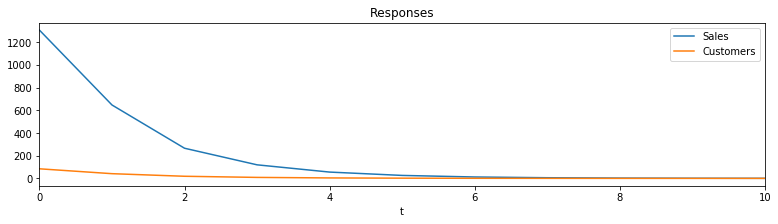

In [324]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Store 31 Model

In [325]:
model1 = VAR(Model_train_endog31)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  20.744716907761035
BIC :  20.781989273608747
FPE :  1021682889.0422587
HQIC:  20.759085940623528 

Lag Order = 2
AIC :  20.73044574512124
BIC :  20.792631988377597
FPE :  1007206158.1103852
HQIC:  20.754420944334353 

Lag Order = 3
AIC :  20.719286777121468
BIC :  20.806439618481974
FPE :  996029970.3170857
HQIC:  20.752889681013183 

Lag Order = 4
AIC :  20.672167465484144
BIC :  20.78433980997273
FPE :  950187483.4830656
HQIC:  20.715419689467446 

Lag Order = 5
AIC :  20.592892658138364
BIC :  20.730137595999082
FPE :  877771681.4713259
HQIC:  20.645815895088397 

Lag Order = 6
AIC :  20.57956124495306
BIC :  20.741932052547256
FPE :  866149915.2825973
HQIC:  20.64217726558663 

Lag Order = 7
AIC :  20.58503386674045
BIC :  20.77258400744951
FPE :  870906478.5668261
HQIC:  20.657364519997873 

Lag Order = 8
AIC :  20.513476490906342
BIC :  20.726259616039997
FPE :  810768396.7384542
HQIC:  20.595543704335697 

Lag Order = 9
AIC :  20.493968526196216
BIC :  20.73

In the above output, the AIC drops to lowest at lag 6

Let’s go with the lag 6.

**Train the VAR Model of Selected Order(p)**

In [326]:
model_fitted1 = model1.fit(6)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:13:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.7419
Nobs:                     737.000    HQIC:                   20.6422
Log likelihood:          -9649.08    FPE:                8.66150e+08
AIC:                      20.5796    Det(Omega_mle):     8.36384e+08
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             2615.273550       554.429738            4.717           0.000
L1.Sales             0.576324         0.090287            6.383           0.000
L1.Customers        -0.903296         1.269862           -0.711 

In [327]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog31.values[-lag_order:]
forecast_input1

6


array([[5403.,  517.],
       [8054.,  684.],
       [5736.,  492.],
       [5982.,  570.],
       [6712.,  582.],
       [7248.,  645.]])

In [328]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog31.index[-nobs:], columns=Model_test_endog31.columns + '_2d')


In [329]:
type(df_forecast1.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [330]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog31.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison31=pd.DataFrame()
model_comparison31.loc[0,'Model']='VAR'
model_comparison31.loc[0,'Variable']='Sales'
model_comparison31.loc[0,'Store']=31
model_comparison31.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog31.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=31
append.loc[0,'RMSE']=rmse

model_comparison31 = model_comparison31.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog31.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog31.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison31.loc[model_comparison31['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog31.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog31.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison31.loc[model_comparison31['Variable']=='Customers', 'MAPE'] = mape

In [331]:
model_comparison31.reset_index(drop=True, inplace=True)
model_comparison31

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,31.0,974.54,14.15
1,VAR,Customers,31.0,66.82,10.47


In [332]:
Model_final = Model_final.append(model_comparison31)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


### VARMAX Model

In [333]:
exog = Model_train_exog31['Promo']
mod = sm.tsa.VARMAX(Model_train_exog31[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  743
Model:                        VARMAX(1,1)   Log Likelihood               -9677.957
                              + intercept   AIC                          19385.915
Date:                    Mon, 05 Apr 2021   BIC                          19455.075
Time:                            22:14:09   HQIC                         19412.576
Sample:                                 0                                         
                                    - 743                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              244.01, 286.42   Jarque-Bera (JB):        386.55, 19.61
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.55, 0.87   Skew:                       0.81, 0.02
P

In [334]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog31[['Promo']] )

In [335]:
f_fst1 = y_fcst.values

In [336]:
VARMAX_Forecast1 = pd.DataFrame(f_fst1,index=Model_test_endog31.index[-nobs:], columns=Model_test_endog31.columns + '_2d')

In [337]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog31.Sales, VARMAX_Forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_31=pd.DataFrame()
model_comparisonMAX_31.loc[0,'Model']='VARMAX'
model_comparisonMAX_31.loc[0,'Variable']='Sales'
model_comparisonMAX_31.loc[0,'Store']=31
model_comparisonMAX_31.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog31.Customers, VARMAX_Forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=31
append.loc[0,'RMSE']=rmse

model_comparisonMAX_31 = model_comparisonMAX_31.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog31.Sales-VARMAX_Forecast1.Sales_2d)
actual = Model_test_endog31.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_31.loc[model_comparisonMAX_31['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog31.Customers-VARMAX_Forecast1.Customers_2d)
actual = Model_test_endog31.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_31.loc[model_comparisonMAX_31['Variable']=='Customers', 'MAPE'] = mape

In [338]:
model_comparisonMAX_31.reset_index(drop=True, inplace=True)
model_comparisonMAX_31

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,31.0,853.01,12.51
1,VARMAX,Customers,31.0,75.54,12.30


In [339]:
Model_final = Model_final.append(model_comparisonMAX_31)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


#### Impulse Response Function

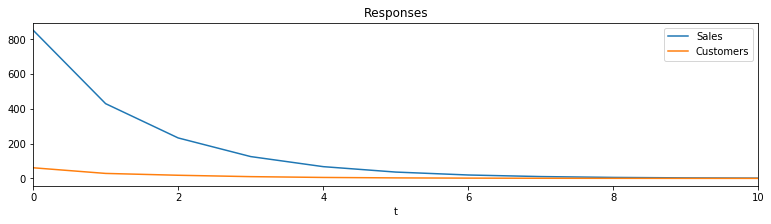

In [340]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Store 46 Model

In [341]:
model1 = VAR(Model_train_endog46)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  21.563453310085627
BIC :  21.608528188813874
FPE :  2316801699.3530946
HQIC:  21.58102525651289 

Lag Order = 2
AIC :  21.524686551679697
BIC :  21.59991117415453
FPE :  2228706938.261179
HQIC:  21.554014288953944 

Lag Order = 3
AIC :  21.47766512165913
BIC :  21.58311975842255
FPE :  2126338828.7348623
HQIC:  21.518781750600017 

Lag Order = 4
AIC :  21.42055257925155
BIC :  21.55631785543858
FPE :  2008306393.6821628
HQIC:  21.47349134990855 

Lag Order = 5
AIC :  21.293378166337586
BIC :  21.459535063847426
FPE :  1768482032.1051292
HQIC:  21.35817247891072 

Lag Order = 6
AIC :  21.211609005092555
BIC :  21.408238864776745
FPE :  1629638973.1024125
HQIC:  21.28829241086036 

Lag Order = 7
AIC :  21.21033043909189
BIC :  21.43751496295958
FPE :  1627570288.8470266
HQIC:  21.298936641346625 

Lag Order = 8
AIC :  21.168776144765424
BIC :  21.426597398205956
FPE :  1561340838.2975147
HQIC:  21.269338999755625 

Lag Order = 9
AIC :  21.173823154013704
BIC :  21.46

In the above output, the AIC drops to lowest at lag 7

Let’s go with the lag 6.

**Train the VAR Model of Selected Order(p)**

In [342]:
model_fitted1 = model1.fit(7)
model_fitted1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Apr, 2021
Time:                     22:14:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.4375
Nobs:                     575.000    HQIC:                   21.2989
Log likelihood:          -7699.75    FPE:                1.62757e+09
AIC:                      21.2103    Det(Omega_mle):     1.54586e+09
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             2005.588626       823.648841            2.435           0.015
L1.Sales            -0.146466         0.112652           -1.300           0.194
L1.Customers         7.696536         1.534053            5.017 

In [343]:
# Get the lag order
lag_order = model_fitted1.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input1 = Model_test_endog46.values[-lag_order:]
forecast_input1

7


array([[ 4902.,   602.],
       [ 5257.,   651.],
       [10068.,   896.],
       [ 6385.,   714.],
       [ 6955.,   716.],
       [ 7057.,   760.],
       [ 7628.,   775.]])

In [344]:
# Forecast
fc = model_fitted1.forecast(y=forecast_input1, steps=nobs)
df_forecast1 = pd.DataFrame(fc,index=Model_test_endog46.index[-nobs:], columns=Model_test_endog46.columns + '_2d')


In [345]:
type(df_forecast1.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [346]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog46.Sales, df_forecast1.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison46=pd.DataFrame()
model_comparison46.loc[0,'Model']='VAR'
model_comparison46.loc[0,'Variable']='Sales'
model_comparison46.loc[0,'Store']=46
model_comparison46.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog46.Customers, df_forecast1.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=46
append.loc[0,'RMSE']=rmse

model_comparison46 = model_comparison46.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog46.Sales-df_forecast1.Sales_2d)
actual = Model_test_endog46.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparison46.loc[model_comparison46['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog46.Customers-df_forecast1.Customers_2d)
actual = Model_test_endog46.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison46.loc[model_comparison46['Variable']=='Customers', 'MAPE'] = mape

In [347]:
model_comparison46.reset_index(drop=True, inplace=True)
model_comparison46

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,46.0,1552.42,22.53
1,VAR,Customers,46.0,97.57,12.93


In [348]:
Model_final = Model_final.append(model_comparison46)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


### VARMAX Model

In [349]:
exog = Model_train_exog46['Promo']
mod = sm.tsa.VARMAX(Model_train_exog46[['Sales','Customers']], order=(1,1), exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  582
Model:                        VARMAX(1,1)   Log Likelihood               -7700.973
                              + intercept   AIC                          15431.946
Date:                    Mon, 05 Apr 2021   BIC                          15497.443
Time:                            22:15:24   HQIC                         15457.477
Sample:                                 0                                         
                                    - 582                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              266.42, 216.12   Jarque-Bera (JB):        492.16, 90.17
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.50, 1.40   Skew:                       1.14, 0.09
P

In [350]:
# Predict
y_pred = res.predict()
# Forecast
y_fcst = res.forecast(steps=nobs, exog=Model_test_exog46[['Promo']] )

**To make dataframe converting forecast into array**

In [351]:
f_fst1 = y_fcst.values

In [352]:
VARMAX_Forecast46 = pd.DataFrame(f_fst1,index=Model_test_endog46.index[-nobs:], columns=Model_test_endog46.columns + '_2d')

In [353]:
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Model_test_endog46.Sales, VARMAX_Forecast46.Sales_2d)).round(2)
#print('Income: RMSE:',  rmse)

model_comparisonMAX_46=pd.DataFrame()
model_comparisonMAX_46.loc[0,'Model']='VARMAX'
model_comparisonMAX_46.loc[0,'Variable']='Sales'
model_comparisonMAX_46.loc[0,'Store']=46
model_comparisonMAX_46.loc[0,'RMSE']=rmse


rmse = np.sqrt(mean_squared_error(Model_test_endog46.Customers, VARMAX_Forecast46.Customers_2d)).round(2)
#print('Sales: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Customers'
append.loc[0,'Store']=46
append.loc[0,'RMSE']=rmse

model_comparisonMAX_46 = model_comparisonMAX_46.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(Model_test_endog46.Sales-VARMAX_Forecast46.Sales_2d)
actual = Model_test_endog46.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Customers: MAPE:',  mape)

model_comparisonMAX_46.loc[model_comparisonMAX_46['Variable']=='Sales', 'MAPE'] = mape

abs_error = np.abs(Model_test_endog46.Customers-VARMAX_Forecast46.Customers_2d)
actual = Model_test_endog46.Customers
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparisonMAX_46.loc[model_comparisonMAX_46['Variable']=='Customers', 'MAPE'] = mape

In [354]:
model_comparisonMAX_46.reset_index(drop=True, inplace=True)
model_comparisonMAX_46

,Model,Variable,Store,RMSE,MAPE
0,VARMAX,Sales,46.0,1139.59,16.02
1,VARMAX,Customers,46.0,81.74,11.32


In [355]:
Model_final = Model_final.append(model_comparisonMAX_46)
Model_final

,Model,Variable,Store,RMSE,MAPE
0,VAR,Sales,1.0,672.68,13.47
1,VAR,Customers,1.0,51.93,7.37
0,VARMAX,Sales,1.0,673.18,14.09
1,VARMAX,Customers,1.0,76.57,13.87
0,VAR,Sales,3.0,2063.28,26.44
1,VAR,Customers,3.0,150.14,19.30
0,VARMAX,Sales,3.0,1061.72,13.52
1,VARMAX,Customers,3.0,113.73,14.20
0,VAR,Sales,8.0,2318.21,30.33
1,VAR,Customers,8.0,207.49,26.56


#### Impulse Response Function

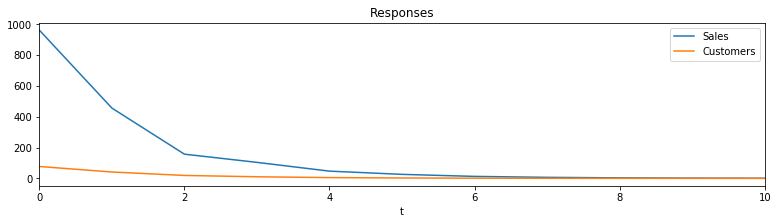

In [356]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses');

## Summary

As per the MAPE table VARMAX is having less MAPE than VAR we can say VARMAX is better model for the stores 